In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import os
import surfplot
import nibabel as nib
import h5py
import scipy.stats as stats
import sklearn.svm as svm
import sklearn
from neuromaps.datasets import fetch_fslr
from statsmodels.stats.multitest import fdrcorrection
%matplotlib inline


In [32]:
parent_dir = "/Users/xiaoxuan/Desktop/Project_task_fMRI/202406_fMRI/data/"
glasser_atlas_str= parent_dir + 'Glasser_LR_Dense64k.dlabel.nii'
glasser_atlas = nib.load(glasser_atlas_str).get_fdata()[0].astype(int)
print("Glassier Atlas shape:", glasser_atlas.shape)

num_regions = 360

Glassier Atlas shape: (64984,)


In [35]:
subj = "sub-03"
sessions = []
excluded_session = 1000
for i in range(1,17):
    if i != excluded_session:
        sessions = sessions + ['ses%d' % i]
runs = ['run-01', 'run-02', 'run-03', 'run-04', 'run-05']
    

# datadir = parent_dir + subj + '/glm_betas/' + subj + "/glm_betas_all_possible_TR_betas_delay_encoding/" + subj + "/" # only include 1 delay and 1 encoding
# datadir = parent_dir + subj + '/glm_betas/' + subj + "/glm_betas_encoding_delay_middle_TR_betas/" + subj + "/" # include long delay 1TR in the middle and corresponding encoding, 
# datadir = parent_dir + subj + '/glm_betas/' + subj + "/glm_betas_encoding_delay_TR_betas/" + subj + "/" 
# datadir = parent_dir + subj + '/glm_betas/' + subj + "/glm_betas_encoding_delay_full_TR_betas/" + subj + "/" # dataset 1: includ all delay periods


# with nilearn fmriprep
datadir = parent_dir + subj + '/glm_betas/' + subj + '/confounds_strategy/' + subj[-2:] + "/" # load confound from confound tsv file
# nilearn_default
# nilearn_simple_load_remove_bg

In [37]:
task_betas = {}
df_conditions = {} # 'task-dmsloc_run-01'
# tasks = ['dmsloc', '1backloc', '1backctg', '1backobj', 'ctxlco' , 'ctxcol', 
#        'interdmsobjABAB', 'interdmslocABBA', 'interdmslocABAB',
#        'interdmsctgABAB', 'interdmsobjABBA','interdmsctgABBA'] 
# tasks = ['1backloc', 'interdmslocABAB', 'interdmslocABBA']
tasks = ['dmsloc']
# tasks = ["interdmslocABAB"]

for task in tasks:
    task_betas[task] = {}
    df_conditions[task]= {}
    print(task)                        
    for sess in sessions:
        task_betas[task][sess] = {}
        df_conditions[task][sess] = {}
        for run in runs:
            
            # file_path = datadir + 'correcttrial_glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '_betas.h5'
            # file_path = datadir + 'correct_glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '_betas.h5'
            # file_path = datadir + 'normalizedglmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '_betas.h5'
            # file_path = datadir + 'glmmethod1_' + sess + '_' + 'task-' + task + "_" + run + "_betas.h5" # dataset 1: includ all delay periods
            
            # for nilearn set of betas
            new_sess = 'ses' + sess[3:].zfill(3)
            file_path = datadir + 'glm_' + new_sess.zfill(3) + "_" + task + "_" + "run" + run[-1:] + "_betas.h5"

            if os.path.exists(file_path):
                print("file path exist")
                h5f = h5py.File(file_path,'r')
                task_betas[task][sess][run] = h5f['betas'][:].copy()
                # df_conditions[task][sess][run] = pd.read_csv(datadir + 'correcttrial_glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '.csv')
                # df_conditions[task][sess][run] = pd.read_csv(datadir + 'glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '.csv')
                df_conditions[task][sess][run] = pd.read_csv(datadir + 'glm_' + new_sess.zfill(3) + "_" + task + "_" + "run" + run[-1:] + ".csv")
                # df_conditions[task][sess][run] = pd.read_csv(datadir + 'glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '.csv')# dataset 1: includ all delay periods
                h5f.close()
                
                
# import os
# import h5py
# import pandas as pd

# task_betas = {}
# df_conditions = {}
# # tasks = ['dmsloc', '1backloc', '1backctg', '1backobj', 'ctxlco', 'ctxcol', 
# #          'interdmsobjABAB', 'interdmslocABBA', 'interdmslocABAB',
# #          'interdmsctgABAB', 'interdmsobjABBA', 'interdmsctgABBA'] 
# tasks = ['dmsloc']

# # Iterate over tasks
# for task in tasks:
#     task_betas[task] = {}
#     df_conditions[task] = {}
#     print(f"Processing task: {task}")                        
#     for sess in sessions:
#         task_betas[task][sess] = {}
#         df_conditions[task][sess] = {}
#         for run in runs:
#             # Construct file path
#             file_path = datadir + 'glmmethod1_' + sess + '_' + 'task-' + task + "_" + run + "_betas.h5"

#             if os.path.exists(file_path):
#                 print(f"File path exists: {file_path}")
#                 try:
#                     # Try to open the file
#                     with h5py.File(file_path, 'r') as h5f:
#                         # Load task betas
#                         task_betas[task][sess][run] = h5f['betas'][:].copy()
                    
#                     # Try to load the CSV file
#                     csv_file_path = datadir + 'glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '.csv'
#                     if os.path.exists(csv_file_path):
#                         df_conditions[task][sess][run] = pd.read_csv(csv_file_path)
#                     else:
#                         print(f"CSV file not found: {csv_file_path}")
#                 except Exception as e:
#                     # Skip files that raise an exception
#                     print(f"Error processing file {file_path}: {e}")
#             else:
#                 print(f"File path does not exist: {file_path}")


dmsloc
file path exist
file path exist
file path exist
file path exist
file path exist
file path exist
file path exist
file path exist
file path exist
file path exist
file path exist
file path exist
file path exist
file path exist
file path exist
file path exist


In [38]:
import copy
def filter_task_betas(task_betas, df_conditions, phase="delay", first_delay_only=True):
    # Use deep copy to avoid modifying the original task_betas and df_conditions
    filtered_task_betas = copy.deepcopy(task_betas)
    filtered_task_df = copy.deepcopy(df_conditions)

    for task in task_betas.keys():
        for sess in task_betas[task].keys():
            for run in task_betas[task][sess].keys():
                task_df = df_conditions[task][sess][run]
                betas = task_betas[task][sess][run]  # of shape 65984 * n_trials
                if first_delay_only:
                    filtered_df = task_df[(task_df['prev_stimulus'] == 1000) & (task_df["regressor_type"] == phase)]
                    betas_phase = betas[:, (task_df['prev_stimulus'] == 1000) & (task_df["regressor_type"] == phase)]
                else:
                    filtered_df = task_df[(task_df["regressor_type"] == phase)]
                    betas_phase = betas[:, (task_df["regressor_type"] == phase)]
                
                filtered_task_betas[task][sess][run] = betas_phase
                filtered_task_df[task][sess][run] = filtered_df

    return filtered_task_betas, filtered_task_df



In [39]:
# concatenate betas together 
def beta_concatenation(contrast_map, excluded_ses = []):
    all_contrast_map_betas = []
    try:
        for taskname in contrast_map.keys():
            for ses in contrast_map[taskname].keys():
                if ses not in excluded_ses:
                    for run in contrast_map[taskname][ses].keys():
                        all_contrast_map_betas.append(contrast_map[taskname][ses][run])
    except:
        for ses in contrast_map[taskname].keys():
            if ses not in excluded_ses:
                for run in contrast_map[taskname][ses].keys():
                    all_contrast_map_betas.append(contrast_map[taskname][ses][run])
        
    all_contrast_map_betas = np.concatenate(all_contrast_map_betas, axis = 1)
    return all_contrast_map_betas.T

# concatenate dataframes together 
def df_concatenation(df, excluded_ses = []):
    all_df = []
    try:
        for taskname in df.keys():
            for ses in df[taskname].keys():
                if ses not in excluded_ses:
                    for run in df[taskname][ses].keys():
                        all_df.append(df[taskname][ses][run])
    except:
        for ses in df[taskname].keys():
            if ses not in excluded_ses:
                for run in df[taskname][ses].keys():
                    all_df.append(contrast_map[taskname][ses][run])
    concatenated_df = pd.concat(all_df, axis=0, ignore_index=True)
 
    return concatenated_df



In [40]:
# check the number of usable trials per run per session per task
n_trials_per_task = {}
ses_indices_per_task = {}
filtered_task_betas, filtered_task_df = filter_task_betas(task_betas, df_conditions, phase = "delay", first_delay_only = True)
for taskname in task_betas.keys():
    n_trials_per_ses = []
    ses_indices_per_task[taskname] = []
    for ses in task_betas[taskname].keys():
        if len(task_betas[taskname][ses].keys()) > 0:
            ses_indices_per_task[taskname].append(ses)
        for run in task_betas[taskname][ses].keys():
            n_trials_per_ses.append(filtered_task_betas[taskname][ses][run].shape[1])
    print("number of trials for task %s per session:" % taskname, n_trials_per_ses)
    print("included session for the given task:", ses_indices_per_task[taskname])
    n_trials_per_task[taskname] = n_trials_per_ses
            

number of trials for task dmsloc per session: [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
included session for the given task: ['ses1', 'ses2', 'ses3', 'ses4', 'ses5', 'ses6', 'ses7', 'ses8', 'ses9', 'ses10', 'ses11', 'ses12', 'ses13', 'ses14', 'ses15', 'ses16']


In [41]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import scipy.stats as stats
import sklearn.metrics
import sklearn.linear_model
from sklearn import svm

def decoding(trainset, testset, trainlabels, testlabels, classifier='distance', confusion=False, feature_normalization=False):
    """ in my experience, distance/pearson based decoding is best for fMRI"""
    
    # Apply feature normalization if requested
    if feature_normalization:
        scaler = StandardScaler()
        trainset = scaler.fit_transform(trainset)  # Fit on trainset and transform
        testset = scaler.transform(testset)        # Transform testset based on trainset statistics
    
    unique_labels = np.unique(trainlabels)
    
    if classifier in ['distance', 'cosine']:
        #### Create prototypes from trainset
        prototypes = {}
        for label in unique_labels:
            ind = np.where(trainlabels == label)[0]
            prototypes[label] = np.mean(trainset[ind, :], axis=0)

        #### Now classify each sample in the testset
        predictions = []
        for i in range(testset.shape[0]):
            # Correlate sample with each prototype
            rs = []
            for label in prototypes:
                if classifier == 'distance':
                    rs.append(stats.pearsonr(prototypes[label], testset[i, :])[0])
                if classifier == 'cosine':
                    rs.append(np.dot(prototypes[label], testset[i, :]) / 
                              (np.linalg.norm(prototypes[label]) * np.linalg.norm(testset[i, :])))
            
            # Find the closest prototype for sample
            max_ind = np.argmax(np.asarray(rs))
            predictions.append(unique_labels[max_ind])

        predictions = np.asarray(predictions)

    elif classifier == 'logistic':
        clf = sklearn.linear_model.LogisticRegression(solver='liblinear')
        clf.fit(trainset, trainlabels)
        predictions = clf.predict(testset)

    elif classifier == 'ridge':
        clf = sklearn.linear_model.RidgeClassifier(solver='svd', max_iter=1000)
        clf.fit(trainset, trainlabels)
        predictions = clf.predict(testset)

    elif classifier == 'svm':
        clf = svm.SVC(kernel='linear', probability=True)
        clf.fit(trainset, trainlabels)
        predictions = clf.predict(testset)

    accuracy = predictions == np.asarray(testlabels)
    confusion_mat = sklearn.metrics.confusion_matrix(testlabels, predictions, labels=unique_labels)

    if confusion:
        return accuracy, confusion_mat
    else:
        return accuracy


In [42]:
import matplotlib.ticker as ticker
def make_brain_surface_plot(data, fig_title, cmap="bwr", center_value=0):
    surfaces = fetch_fslr()
    lh, rh = surfaces['veryinflated']
    surface_dat = np.zeros((len(glasser_atlas),))
    
    for roi in range(num_regions):
        roi_ind = np.where(glasser_atlas == roi + 1)[0]
        surface_dat[roi_ind] = data[roi_ind]
    
    # Center the color range around the specified center_value
    if cmap == "bwr":
        max_abs_dev = np.max(np.abs(surface_dat - center_value))
        vmin, vmax = center_value - max_abs_dev, center_value + max_abs_dev
    else:
        vmin, vmax = np.min(surface_dat), np.max(surface_dat)

    # Create the plot with the colormap and centered color range
    p = surfplot.Plot(lh, rh, size=(500, 350), zoom=1.8)
    p.add_layer(surface_dat.T, cmap=cmap, color_range=[vmin, vmax])
    
    # Build the figure and add a colorbar
    fig = p.build(figsize=(4, 4), colorbar=True, cbar_kws={'fontsize': 8})
    
    # Access the colorbar and format the ticks
    cbar = fig.axes[-1]  # The colorbar is usually the last axis
    cbar.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))  # Set colorbar format to 1 decimal place
    
    # Add a title
    fig.suptitle(fig_title, y=0.98, fontsize=14)
    
    # Adjust layout
    fig.tight_layout()



In [43]:
# # create region mapping
import pandas as pd

# map_df_lh = pd.read_excel(basedir + 'Glasser_2016_Table.xlsx')
# map_df_lh = map_df_lh.iloc[:,0:2]


# # Insert row with region 0
# map_df_lh.loc[-1] = [0, 'LG'] # ? region 0 as the white matter/subcortex?
# map_df_lh.index = map_df_lh.index + 1  # shifting index
# map_df_lh = map_df_lh.sort_index().reset_index(drop=True)

# # # Rename columns
# map_df_lh.columns = ['region_id', 'region_name']

# # # Ensure region_id is numeric
# map_df_lh['region_id'] = pd.to_numeric(map_df_lh['region_id'], errors='coerce')

# # # Copy the left hemisphere DataFrame for the right hemisphere
# map_df_rh = map_df_lh.copy()

# # # Increase map_df_rh region_id by 180 and index by 180
# map_df_rh['region_id'] = map_df_rh['region_id'] + 180
# map_df_rh.index = map_df_rh.index + 180

# # # Concatenate both hemispheres
# map_df = pd.concat([map_df_lh, map_df_rh], axis=0).reset_index(drop=True)

# mapped_atlas = {}

# for id, name in zip(map_df['region_id'], map_df['region_name']):
#     # indexes of id in glasser_atlas
#     if str(name) not in mapped_atlas.keys():
#         mapped_atlas[str(name)] = np.where(glasser_atlas == id)[0]
#     else:
#         mapped_atlas[str(name)] = np.concatenate((mapped_atlas[str(name)], np.where(glasser_atlas == id)[0]))


In [44]:
# mapped_atlas.keys() # all possible the Area/nName here?

In [45]:
# # sample data from a given brain region
# # todo: need mapped atlas, which require udpate
# def regionwise_beta(task_betas, mapped_atlas, region = "V1"):

#     if region == "whole_brain":
#         return task_betas
        
#     regionwise_task_betas = {}

#     for task in task_betas.keys():
#         regionwise_task_betas[task] = {}
#         for sess in task_betas[task].keys():
#             regionwise_task_betas[task][sess] = {}
#             for run in task_betas[task][sess].keys():
                
#                 region_idx = mapped_atlas[region]
#                 betas  = task_betas[task][sess][run][region_idx,:]

#                 regionwise_task_betas[task][sess][run] = betas
#     return regionwise_task_betas


In [46]:
# # Subsample regions that have data
# regions_to_delete = []

# for region in mapped_atlas.keys():
#     regionwise_task_betas = regionwise_beta(filtered_task_betas, mapped_atlas, region=region)
#     for task in regionwise_task_betas.keys():
#         for ses in regionwise_task_betas[task].keys():
#             if len(regionwise_task_betas[task][ses]) == 0:
#                 continue
#             for run in regionwise_task_betas[task][ses].keys():
#                 if regionwise_task_betas[task][ses][run].shape[0] == 0:
#                     regions_to_delete.append(region)
#                     break  # Exit loop to avoid further processing for this region



In [47]:
# # Delete regions outside the loop to avoid modifying the dictionary during iteration
# for region in set(regions_to_delete):
#     del mapped_atlas[region]


In [48]:
# mapped_atlas.keys() # all possible the Area/nName here?

In [49]:
# print(len(mapped_atlas.keys()) )

## sanity check: what is the best performed decoder?

for each task, for each feature, for given brain region and subsampled beta, test various type of decoders on betas concatenated across all sessions

In [50]:
# Within each session, for each task, calculate the contrast beta between the encoding and delay period
delay_task_betas, delay_task_df = filter_task_betas(task_betas, df_conditions, phase="delay", first_delay_only=False)
encoding_task_betas, encoding_task_df = filter_task_betas(task_betas, df_conditions, phase="encoding", first_delay_only=False)

In [51]:
from scipy import stats
from sklearn import svm
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import cross_val_score, StratifiedKFold
from statsmodels.stats.multitest import multipletests

In [24]:


# # Flag to toggle significance testing
# perform_significance_test = True  # Set to False to bypass significance testing

# # Concatenate across all sessions and all tasks, for now, only dms_loc task is included (depends on the task list)
# all_delay_betas = beta_concatenation(delay_task_betas)
# all_encoding_betas = beta_concatenation(encoding_task_betas)
# all_df = df_concatenation(delay_task_df)

# decoding_feature = "location"
# phase = "delay"
# classifier='distance'
# feature_normalization = True

# # Initialize maps and lists
# significant_decodable_region_index = []

# regionwise_acc = np.zeros((64984, 1))
# t_stats_map = np.zeros((64984, 1))
# p_values_map = np.zeros((64984, 1))
# p_values_list = []  # Collect all p-values for FDR correction. Q: FDR correction on all brain regions?


# # Iterate through each brain region
# for region in range(1, 361):
#     region_idx = np.where(glasser_atlas==region)[0]
#     if phase == "delay":
#         data = all_delay_betas[:, region_idx]
#     else:
#         data = all_encoding_betas[:, region_idx]

#     labels = all_df[decoding_feature].to_numpy()
    
#     # Ensure that the region has data
#     if data.shape[-1] != 0:
        
#         # Set up Stratified K-Fold cross-validation
#         skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        
#         # Collect accuracy for each fold
#         fold_accuracies = []
#         for train_index, test_index in skf.split(data, labels):
#             trainset, testset = data[train_index], data[test_index]
#             trainlabels, testlabels = np.array(labels)[train_index], np.array(labels)[test_index]
#             accuracy = decoding(trainset, testset, trainlabels, testlabels, classifier=classifier, confusion=False, feature_normalization=feature_normalization)
#             fold_accuracies.append(np.mean(accuracy))
#         t_stat, p_val = ttest_1samp(fold_accuracies, popmean=0.5, alternative='greater')
#         t_stats_map[region_idx] = t_stat
#         p_values_map[region_idx] = p_val
        
#     print(np.mean(fold_accuracies))
#     regionwise_acc[region_idx] = np.mean(fold_accuracies)
    

0.5666666666666667
0.5703703703703704
0.537037037037037
0.55
0.6203703703703705
0.5777777777777777
0.5796296296296297
0.5018518518518518
0.49259259259259264
0.5074074074074073
0.4851851851851852
0.4981481481481481
0.5277777777777778
0.4851851851851852
0.49259259259259264
0.5685185185185184
0.49259259259259264
0.6148148148148149
0.5296296296296297
0.5537037037037037
0.5444444444444445
0.524074074074074
0.5833333333333333
0.49074074074074076
0.5296296296296297
0.48888888888888893
0.5
0.47037037037037044
0.4499999999999999
0.5462962962962964
0.5425925925925926
0.5222222222222223
0.47592592592592586
0.5000000000000001
0.537037037037037
0.475925925925926
0.5648148148148149
0.4722222222222222
0.4833333333333333
0.5481481481481482
0.4833333333333333
0.5074074074074074
0.4981481481481481
0.5148148148148148
0.49444444444444446
0.5111111111111111
0.524074074074074
0.5166666666666667
0.4185185185185185
0.4888888888888888
0.4666666666666667
0.5037037037037038
0.4685185185185185
0.512962962962963
0

In [52]:
# exclude 1-session out
from scipy import stats
from sklearn import svm
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import cross_val_score, StratifiedKFold
from statsmodels.stats.multitest import multipletests

# Flag to toggle significance testing
perform_significance_test = True  # Set to False to bypass significance testing



decoding_feature = "location"
phase = "delay"
classifier='distance'
feature_normalization = True

# Initialize maps and lists
significant_decodable_region_index = []

regionwise_acc = np.zeros((64984, 1))
t_stats_map = np.zeros((64984, 1))
p_values_map = np.zeros((64984, 1))
p_values_list = []  # Collect all p-values for FDR correction. Q: FDR correction on all brain regions?


# Iterate through each brain region
for region in range(1, 361):
    region_idx = np.where(glasser_atlas==region)[0]

    # Collect accuracy for each fold
    fold_accuracies = []

    for exclude_ses in sessions:
        exclude_ses = [exclude_ses]
        # Concatenate across all sessions and all tasks, for now, only dms_loc task is included (depends on the task list)
        all_delay_betas = beta_concatenation(delay_task_betas, exclude_ses)
        all_encoding_betas = beta_concatenation(encoding_task_betas, exclude_ses)
        all_df = df_concatenation(delay_task_df, exclude_ses)
    
        
        if phase == "delay":
            data = all_delay_betas[:, region_idx]
        else:
            data = all_encoding_betas[:, region_idx]
    
        labels = all_df[decoding_feature].to_numpy()
    
        # Ensure that the region has data
        if data.shape[-1] != 0:
            
            # Set up Stratified K-Fold cross-validation
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            
            
            for train_index, test_index in skf.split(data, labels):
                trainset, testset = data[train_index], data[test_index]
                trainlabels, testlabels = np.array(labels)[train_index], np.array(labels)[test_index]
                accuracy = decoding(trainset, testset, trainlabels, testlabels, classifier=classifier, confusion=False, feature_normalization=feature_normalization)
                fold_accuracies.append(np.mean(accuracy))
            t_stat, p_val = ttest_1samp(fold_accuracies, popmean=0.5, alternative='greater')
            t_stats_map[region_idx] = t_stat
            p_values_map[region_idx] = p_val
            
    print(np.mean(fold_accuracies))
    regionwise_acc[region_idx] = np.mean(fold_accuracies)
    

0.7861979166666667
0.5966145833333332
0.5348958333333333
0.7450520833333334
0.7372395833333333
0.7348958333333333
0.6841145833333334
0.48359375
0.5216145833333334
0.51953125
0.4825520833333333
0.5697916666666666
0.6661458333333333
0.5151041666666667
0.4520833333333334
0.5776041666666667
0.6223958333333333
0.7197916666666666
0.5341145833333334
0.6328125
0.7161458333333333
0.7625
0.5286458333333334
0.51328125
0.47109375
0.5166666666666667
0.6010416666666666
0.4744791666666666
0.55859375
0.5216145833333333
0.5828125
0.5135416666666666
0.5098958333333334
0.4541666666666666
0.5278645833333333
0.4802083333333334
0.4770833333333333
0.5239583333333334
0.4744791666666666
0.4796875
0.5052083333333333
0.4768229166666667
0.4921875
0.48125
0.6109375
0.4734375
0.46328125
0.4567708333333333
0.59609375
0.49453125
0.4533854166666666
0.46796875
0.52265625
0.49296875
0.46796875
0.4924479166666666
0.4640625
0.5221354166666666
0.4796875
0.50078125
0.4526041666666666
0.4552083333333333
0.5721354166666667
0.

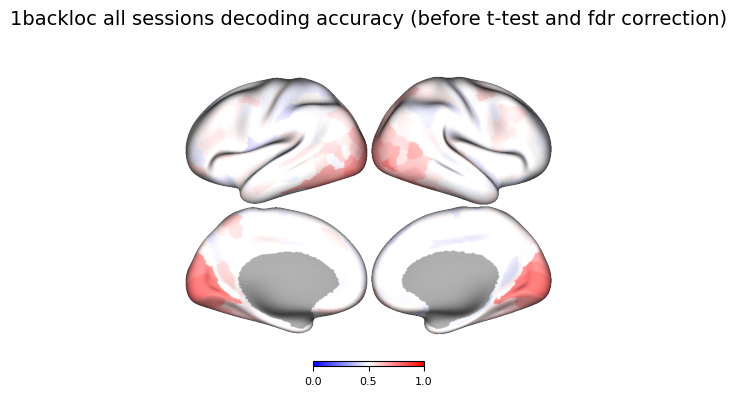

In [53]:
# Plot brain surface on accuracies
make_brain_surface_plot(np.squeeze(regionwise_acc), f"1backloc all sessions decoding accuracy (before t-test and fdr correction)", center_value = 0.5)


In [27]:
# Apply FDR correction
reject, pvals_corrected, _, _ = multipletests(p_values_map.squeeze(), alpha=0.05, method='fdr_bh')

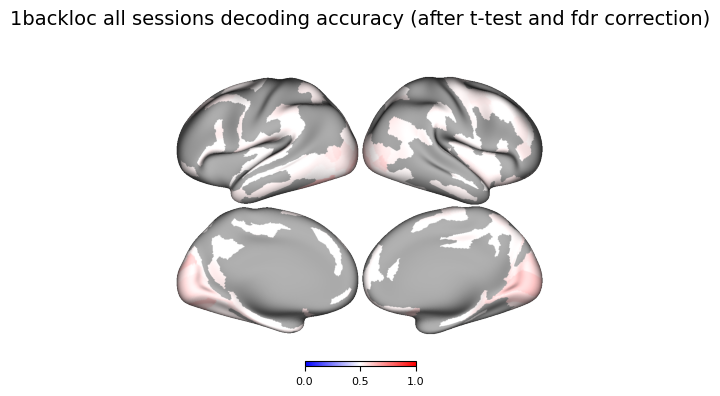

In [29]:
# Plot brain surface on accuracies
fdr_corrected_acc = np.zeros((64984, 1))
fdr_corrected_acc[reject] = regionwise_acc[reject]
make_brain_surface_plot(np.squeeze(fdr_corrected_acc), f"1backloc all sessions decoding accuracy (after t-test and fdr correction)", center_value = 0.5)


In [ ]:
from sklearn.model_selection import train_test_split
import seaborn as sns
is_confusion = True
n_bootstraps = 10

test_size = 0.1  # 10% for testing, 80% for training
# metrics = ['logistic']
metrics = ['distance','cosine', 'logistic', 'ridge']
decoding_features = [ "location", "category","object", ]

# Initialize a dictionary to store the maximum accuracies
max_accuracies = {task: {feature: [] for feature in decoding_features} for task in regionwise_task_betas.keys()}

# Iterate through decoding features and metrics
for task in regionwise_task_betas.keys():
    
    if task == "1backctg" or task == "1backobj": continue
    print(task)
    for decoding_feature in decoding_features:
        print(decoding_feature)
        for metric in metrics:
            
            
            accs = []
            for region in mapped_atlas.keys():
                if region == 'Area\nName' or region == 'MST': 
                    continue

                # Get regionwise betas
                regionwise_task_betas = regionwise_beta(filtered_task_betas, mapped_atlas, region=region)
                curr_task_betas = regionwise_task_betas[task]

                # Collect data and labels
                concatenated_data = []
                labels = []
                for ses in curr_task_betas.keys():
                    if len(curr_task_betas[ses]) == 0:
                        continue
                    for run in curr_task_betas[ses].keys():
                        concatenated_data.append(curr_task_betas[ses][run].T)
                        labels.extend(list(filtered_task_df[task][ses][run][decoding_feature].to_numpy()))
                concatenated_data = np.concatenate(concatenated_data, axis=0)

                curr_acc = []
                for _ in range(n_bootstraps):
                    # Split the data
                    train_data, test_data, train_labels, test_labels = train_test_split(
                        concatenated_data, labels, test_size=test_size)
                    
                    
                    # Perform decoding
                    accuracy, _ = decoding(train_data, test_data, train_labels, test_labels, classifier=metric, confusion=is_confusion)
                    curr_acc.append(np.mean(accuracy))
                accs.append(np.mean(curr_acc))
            print(np.max(accs))
            # Record the maximum accuracy for the task, feature, and metric
            max_accuracies[task][decoding_feature].append(np.max(accs))


In [170]:
max_accuracies

{'1backloc': {'location': [0.9090909090909091,
   0.9090909090909091,
   0.9090909090909091,
   1.0],
  'category': [0.8181818181818182,
   0.9090909090909091,
   0.9090909090909091,
   1.0],
  'object': [0.6363636363636364,
   0.7272727272727273,
   0.7272727272727273,
   0.7272727272727273]},
 '1backctg': {'location': [], 'category': [], 'object': []},
 '1backobj': {'location': [], 'category': [], 'object': []},
 'ctxlco': {'location': [0.7777777777777778,
   0.7407407407407407,
   0.7407407407407407,
   0.8148148148148148],
  'category': [0.7407407407407407,
   0.7407407407407407,
   0.7037037037037037,
   0.7777777777777778],
  'object': [0.48148148148148145,
   0.48148148148148145,
   0.5185185185185185,
   0.4444444444444444]},
 'ctxcol': {'location': [0.7391304347826086,
   0.8260869565217391,
   0.8260869565217391,
   0.7391304347826086],
  'category': [0.782608695652174,
   0.782608695652174,
   0.782608695652174,
   0.782608695652174],
  'object': [0.43478260869565216,
   0.5

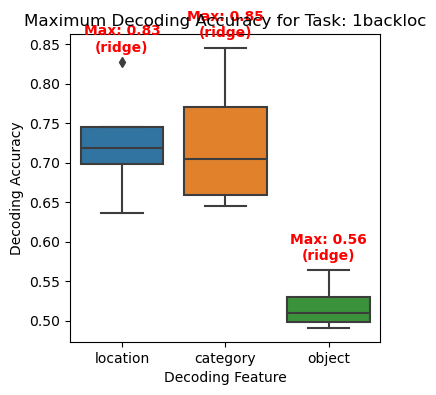

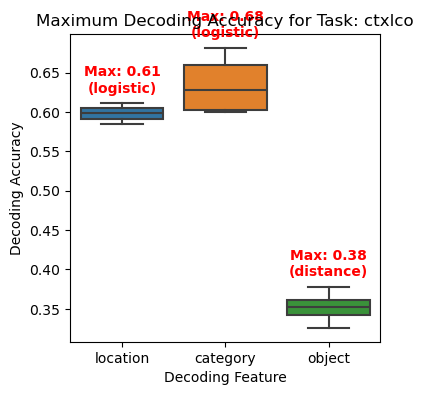

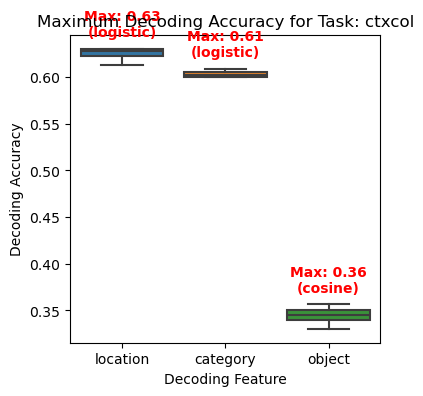

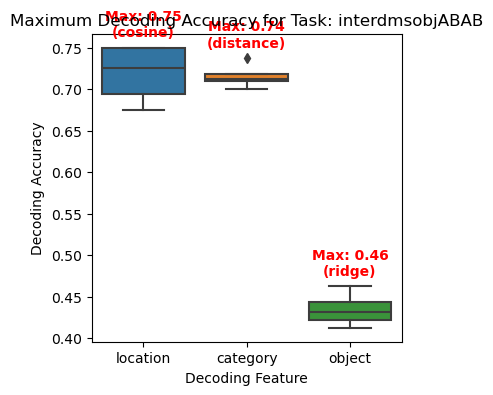

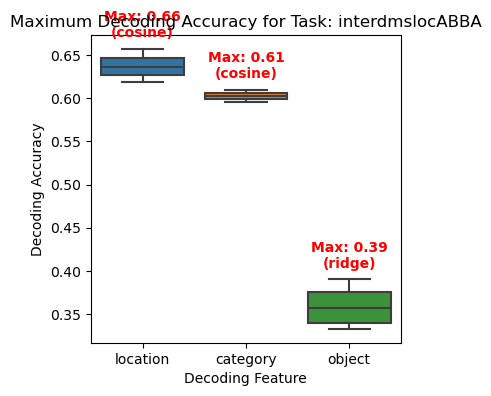

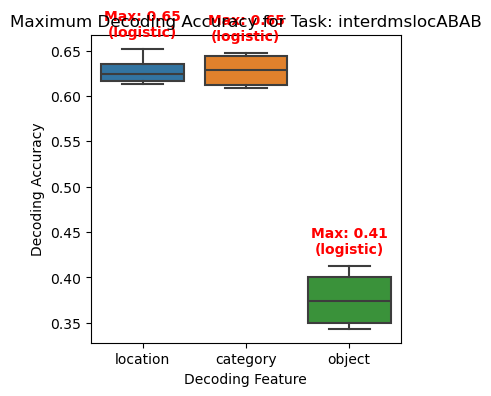

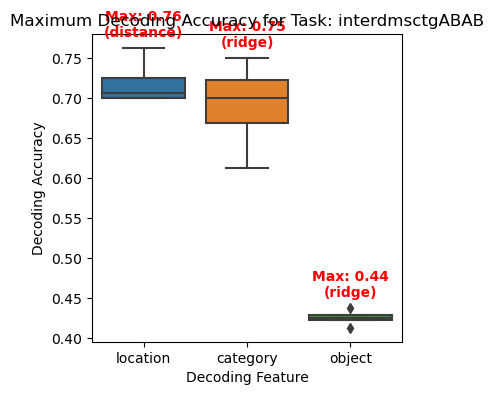

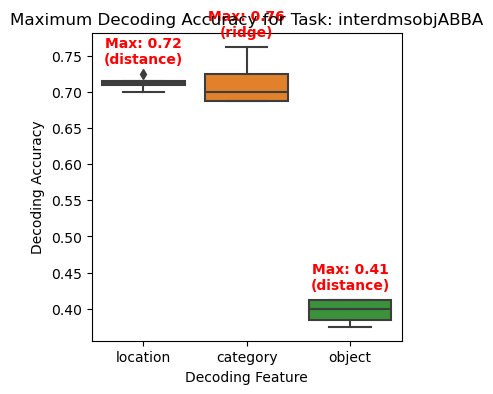

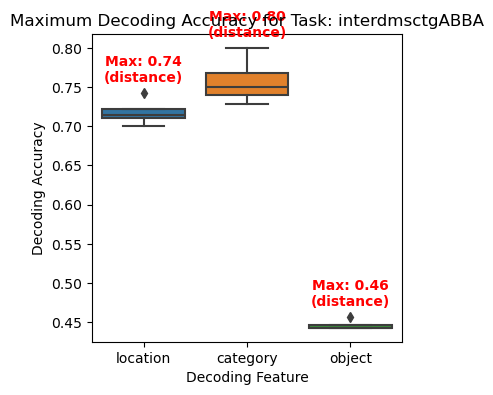

In [57]:
import seaborn as sns

del max_accuracies["1backctg"]
del max_accuracies["1backobj"]
for task in max_accuracies.keys():
    plt.figure(figsize=(4, 4))
    data_to_plot = [max_accuracies[task][feature] for feature in decoding_features]
    
    # Create the box plot
    sns.boxplot(data=data_to_plot)
    
    # Annotate each box with its maximum accuracy and corresponding metric
    for feature_index, feature in enumerate(decoding_features):
        max_acc_for_feature = np.max(max_accuracies[task][feature])
        corresponding_metric = metrics[np.argmax(max_accuracies[task][feature])]  # Find the metric corresponding to max accuracy
        
        # Calculate the position of the text annotation
        x_position = feature_index
        y_position = max_acc_for_feature + 0.01  # Slightly above the max value
        
        # Add annotation to the plot
        plt.text(x_position, y_position, f'Max: {max_acc_for_feature:.2f}\n({corresponding_metric})',
                 ha='center', va='bottom', fontsize=10, color='red', weight='bold')
    
    # Set plot labels and titles
    plt.xticks(ticks=np.arange(len(decoding_features)), labels=decoding_features)
    plt.title(f'Maximum Decoding Accuracy for Task: {task}')
    plt.ylabel('Decoding Accuracy')
    plt.xlabel('Decoding Feature')
    
    


## sanity check: how does decoding accuracy increase with number of stimuli repetitions? 

In [58]:
# record maximum accuracy, with increased train/test split
# Initialize a dictionary to store the best metric for each task and feature
best_metrics = {task: {} for task in max_accuracies.keys()}

# Identify the metric with the highest accuracy for each task and feature
for task in max_accuracies.keys():
    for feature in decoding_features:
        accuracies = max_accuracies[task][feature]
        best_metric_index = np.argmax(accuracies)
        best_metric = metrics[best_metric_index]
        best_metrics[task][feature] = best_metric


In [59]:
test_sizes = np.linspace(0.1, 0.5, 5)  # Example: test sizes from 10% to 50%
accuracy_increase = {task: {feature: [] for feature in decoding_features} for task in max_accuracies.keys()}

for task in regionwise_task_betas.keys():
    if task == "1backctg" or task == "1backobj": continue
    for feature in decoding_features:
        best_metric = best_metrics[task][feature]
        print("what is the best metric:", best_metric)
        for test_size in test_sizes:
            accs = []
            for region in mapped_atlas.keys():
                if region == 'Area\nName': 
                    continue

                # Get regionwise betas
                regionwise_task_betas = regionwise_beta(filtered_task_betas, mapped_atlas, region=region)
                curr_task_betas = regionwise_task_betas[task]

                # Collect data and labels
                concatenated_data = []
                labels = []
                for ses in curr_task_betas.keys():
                    if len(curr_task_betas[ses]) == 0:
                        continue
                    for run in curr_task_betas[ses].keys():
                        concatenated_data.append(curr_task_betas[ses][run].T)
                        labels.extend(list(filtered_task_df[task][ses][run][feature].to_numpy()))
                concatenated_data = np.concatenate(concatenated_data, axis=0)

                # Split the data with the current test_size
                train_data, test_data, train_labels, test_labels = train_test_split(
                    concatenated_data, labels, test_size=test_size)
                
                # Perform decoding using the best metric
                accuracy, _ = decoding(train_data, test_data, train_labels, test_labels, classifier=best_metric, confusion=is_confusion)
                accs.append(np.mean(accuracy))
            
            # Record the max accuracy for the current test_size
            accuracy_increase[task][feature].append(np.max(accs))
            print(np.max(accs))


what is the best metric: ridge
0.9090909090909091
0.9545454545454546
0.9090909090909091
0.8372093023255814
0.8703703703703703
what is the best metric: ridge
1.0
0.9090909090909091
0.8787878787878788
0.8604651162790697
0.8148148148148148
what is the best metric: ridge
0.7272727272727273
0.6363636363636364
0.7272727272727273
0.6976744186046512
0.5740740740740741
what is the best metric: logistic


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan

0.7407407407407407


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan

0.6851851851851852


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.6419753086419753


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.6203703703703703
0.6343283582089553
what is the best metric: logistic


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan

0.6666666666666666


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan

0.6481481481481481


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.6419753086419753
0.6481481481481481
0.6194029850746269
what is the best metric: distance
0.4074074074074074
0.4444444444444444
0.3950617283950617
0.4166666666666667
0.3358208955223881
what is the best metric: logistic


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan

0.782608695652174


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan

0.717391304347826


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan

0.6666666666666666


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan

0.6521739130434783


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.6140350877192983
what is the best metric: logistic


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan

0.8260869565217391


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan

0.6739130434782609


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan

0.6521739130434783


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan

0.6521739130434783


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.6140350877192983
what is the best metric: cosine
0.4782608695652174
0.45652173913043476
0.37681159420289856
0.3804347826086957
0.35964912280701755
what is the best metric: cosine
0.875
0.8666666666666667
0.8181818181818182
0.7333333333333333
0.6756756756756757
what is the best metric: distance
1.0
0.8
0.8181818181818182
0.7
0.6756756756756757
what is the best metric: ridge
0.75
0.6
0.5454545454545454
0.4666666666666667
0.4594594594594595
what is the best metric: cosine
0.7619047619047619
0.6904761904761905
0.6507936507936508
0.6506024096385542
0.6346153846153846
what is the best metric: cosine
0.7619047619047619
0.6904761904761905
0.6666666666666666
0.6144578313253012
0.6153846153846154
what is the best metric: ridge
0.5238095238095238
0.40476190476190477
0.38095238095238093
0.37349397590361444
0.38461538461538464
what is the best metric: logistic


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan

0.7391304347826086


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.7111111111111111


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.6716417910447762


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.6222222222222222
0.6160714285714286
what is the best metric: logistic


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan

0.782608695652174


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan

0.6888888888888889
0.6268656716417911
0.6888888888888889
0.6339285714285714
what is the best metric: logistic


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan

0.4782608695652174


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan

0.4444444444444444


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan

0.40298507462686567


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.37777777777777777


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.3482142857142857
what is the best metric: distance
0.875
0.8
0.8260869565217391
0.7333333333333333
0.7837837837837838
what is the best metric: ridge
0.875
0.7333333333333333
0.7391304347826086
0.7
0.6486486486486487
what is the best metric: ridge
0.625
0.5333333333333333
0.4782608695652174
0.4666666666666667
0.4864864864864865
what is the best metric: distance
0.875
0.8125
0.7083333333333334
0.6875
0.725
what is the best metric: ridge
0.875
0.75
0.7083333333333334
0.6875
0.675
what is the best metric: distance
0.625
0.5625
0.4166666666666667
0.40625
0.375
what is the best metric: distance
1.0
0.7857142857142857
0.85
0.7407407407407407
0.7272727272727273
what is the best metric: distance
1.0
0.8571428571428571
0.75
0.7407407407407407
0.7272727272727273
what is the best metric: distance
0.7142857142857143
0.5714285714285714
0.5
0.48148148148148145
0.42424242424242425


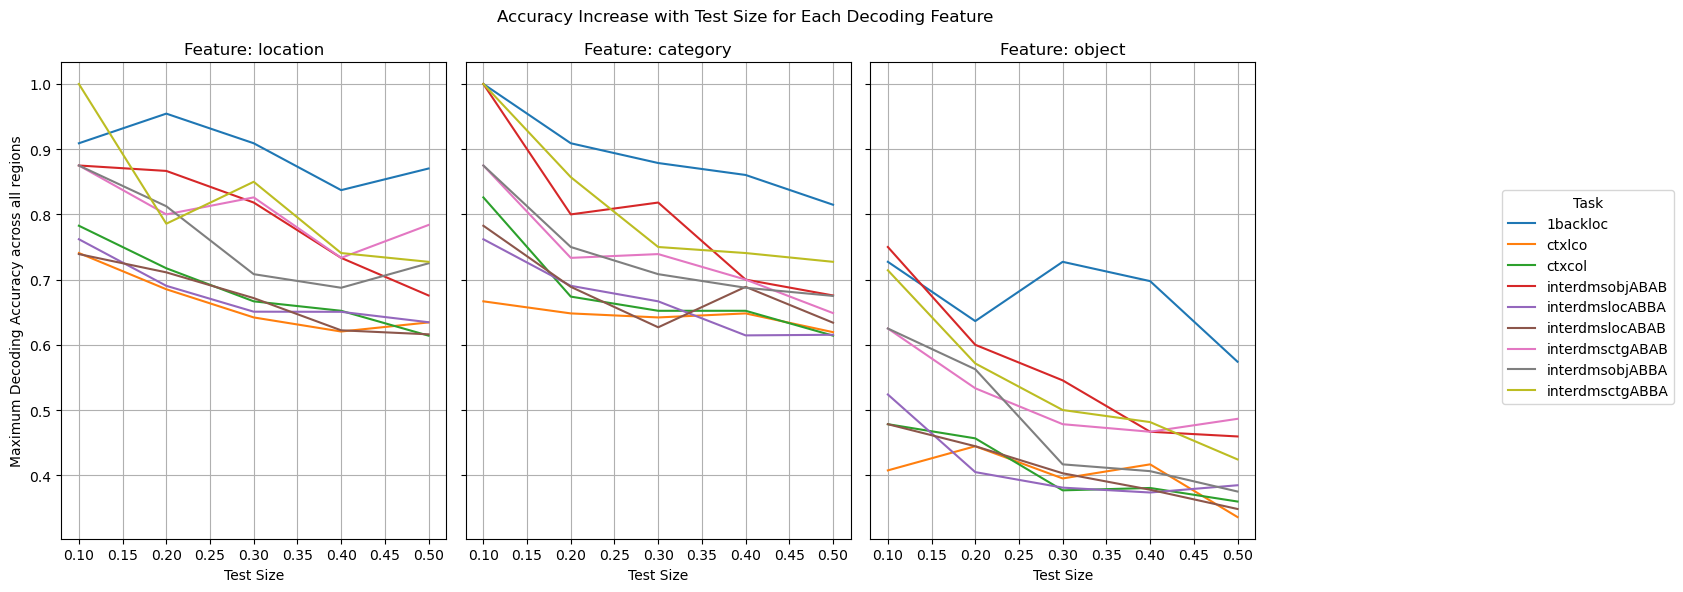

In [61]:
import matplotlib.pyplot as plt

# Set up subplots: one subplot per decoding feature
fig, axes = plt.subplots(nrows=1, ncols=len(decoding_features), figsize=(15, 6), sharey=True)

for i, feature in enumerate(decoding_features):
    for task in accuracy_increase.keys():
        axes[i].plot(test_sizes, accuracy_increase[task][feature], label=f'{task}')
    
    axes[i].set_xlabel('Test Size')
    axes[i].set_title(f'Feature: {feature}')
    axes[i].grid(True)

# Set shared y-label
axes[0].set_ylabel('Maximum Decoding Accuracy across all regions')

# Add a single legend outside the subplots
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5), title="Task")

# Set the overall title
plt.suptitle('Accuracy Increase with Test Size for Each Decoding Feature')

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Show the plot
plt.show()


## sanity check: is the decoder performance generalizable to unseen sessions?

In [85]:
generalization_accuracy = {task: {feature: [] for feature in decoding_features} for task in max_accuracies.keys()}
generalization_accuracy_min = {task: {feature: [] for feature in decoding_features} for task in max_accuracies.keys()}
corres_test_ratio_accuracy = {task: {feature: [] for feature in decoding_features} for task in max_accuracies.keys()}
linspace_array = np.linspace(0.1, 0.5, 5)
for task in regionwise_task_betas.keys():
    if task == "1backctg" or task == "1backobj": continue
    for feature in decoding_features:
        # best_metric = best_metrics[task][feature]
        # print("what is the best metric:", best_metric)
        best_metric = "ridge"
        
        all_sess = ses_indices_per_task[task]
        for eval_ses in all_sess:
            train_ses = list(set(all_sess) - set([eval_ses]))
            for ses in train_ses:
                if ses in eval_ses:
                    print(ses)
                
            print("what is train_ses:", train_ses)
            print("what is eval_ses:", eval_ses)
            accs = []
            for region in mapped_atlas.keys():
                if region == 'Area\nName': 
                    continue

                # Get regionwise betas
                regionwise_task_betas = regionwise_beta(filtered_task_betas, mapped_atlas, region=region)
                curr_task_betas = regionwise_task_betas[task]

                # Collect data and labels
                train_data = []
                train_labels = []
                test_data = []
                test_labels = []
                for ses in train_ses:
                    if ses == eval_ses: continue
                    for run in curr_task_betas[ses].keys():
                        train_data.append(curr_task_betas[ses][run].T)
                        train_labels.extend(list(filtered_task_df[task][ses][run][feature].to_numpy()))
                        
                train_data = np.concatenate(train_data, axis=0)

                
                for run in curr_task_betas[eval_ses].keys():
                    test_data.append(curr_task_betas[eval_ses][run].T)
                    test_labels.extend(list(filtered_task_df[task][eval_ses][run][feature].to_numpy()))
                test_data = np.concatenate(test_data, axis=0)

                
                # Perform decoding using the best metric
                accuracy, _ = decoding(train_data, test_data, train_labels, test_labels, classifier=best_metric, confusion=is_confusion)
                accs.append(np.mean(accuracy))
            test_data = np.concatenate(test_data, axis=0)
            test_data_ratio = len(test_labels)/len(train_labels + test_labels)
            print("test ratio:", test_data_ratio)
            closest_index = np.argmin(np.abs(linspace_array - test_data_ratio))
            
            # Record the max accuracy for the current test_size
            generalization_accuracy[task][feature].append(np.max(accs))
            # generalization_accuracy_min[task][feature].append(np.min(accs))
            
            print(np.max(accs))
        # corres_test_ratio_accuracy[task][feature] = accuracy_increase[task][feature][closest_index]


what is train_ses: ['ses15', 'ses13', 'ses8', 'ses7', 'ses14', 'ses4', 'ses9', 'ses2', 'ses3', 'ses16', 'ses10']
what is eval_ses: ses1
test ratio: 0.07476635514018691
1.0
what is train_ses: ['ses15', 'ses1', 'ses13', 'ses8', 'ses7', 'ses14', 'ses4', 'ses9', 'ses3', 'ses16', 'ses10']
what is eval_ses: ses2
test ratio: 0.08411214953271028
1.0
what is train_ses: ['ses15', 'ses1', 'ses13', 'ses8', 'ses7', 'ses14', 'ses4', 'ses9', 'ses2', 'ses16', 'ses10']
what is eval_ses: ses3
test ratio: 0.08411214953271028
1.0
what is train_ses: ['ses15', 'ses1', 'ses13', 'ses8', 'ses7', 'ses14', 'ses9', 'ses2', 'ses3', 'ses16', 'ses10']
what is eval_ses: ses4
test ratio: 0.08411214953271028
1.0
what is train_ses: ['ses15', 'ses1', 'ses13', 'ses8', 'ses14', 'ses4', 'ses9', 'ses2', 'ses3', 'ses16', 'ses10']
what is eval_ses: ses7
test ratio: 0.08411214953271028
0.8888888888888888
what is train_ses: ['ses15', 'ses1', 'ses13', 'ses7', 'ses14', 'ses4', 'ses9', 'ses2', 'ses3', 'ses16', 'ses10']
what is eval

In [189]:
generalization_accuracy

{'1backloc': {'location': [1.0,
   0.9090909090909091,
   1.0,
   1.0,
   1.0,
   0.9090909090909091,
   0.9090909090909091,
   1.0,
   0.9090909090909091,
   1.0,
   1.0,
   1.0],
  'category': [0.9090909090909091,
   1.0,
   0.9090909090909091,
   0.8181818181818182,
   1.0,
   1.0,
   0.9090909090909091,
   1.0,
   1.0,
   0.9090909090909091,
   0.9090909090909091,
   0.9090909090909091],
  'object': [0.9090909090909091,
   0.9090909090909091,
   0.9090909090909091,
   0.9090909090909091,
   0.9090909090909091,
   0.9090909090909091,
   0.9090909090909091,
   0.9090909090909091,
   0.8181818181818182,
   0.8181818181818182,
   0.8181818181818182,
   0.8181818181818182]},
 'ctxlco': {'location': [1.0,
   0.9090909090909091,
   1.0,
   1.0,
   1.0,
   0.9090909090909091,
   1.0,
   0.9090909090909091,
   0.8181818181818182,
   1.0,
   0.9090909090909091,
   0.9090909090909091],
  'category': [0.9090909090909091,
   0.9090909090909091,
   0.9090909090909091,
   0.9090909090909091,
   0

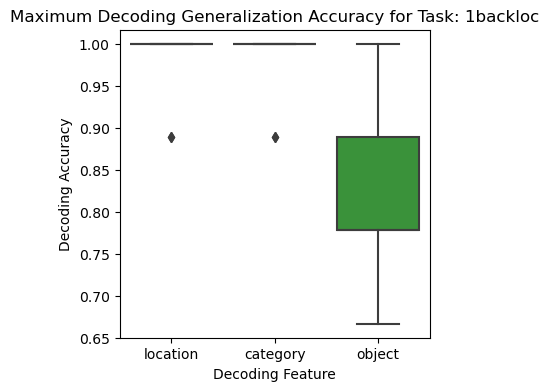

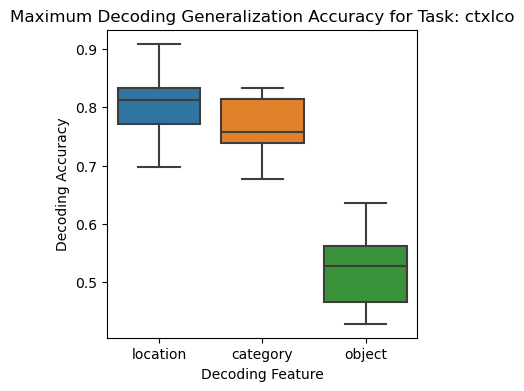

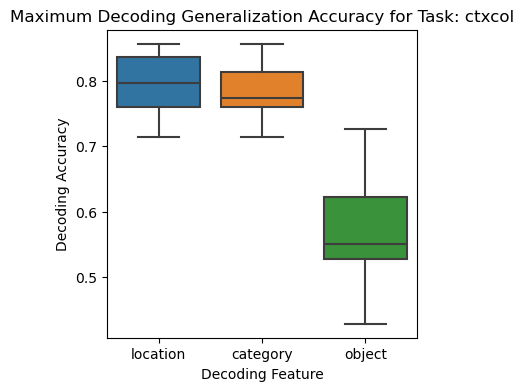

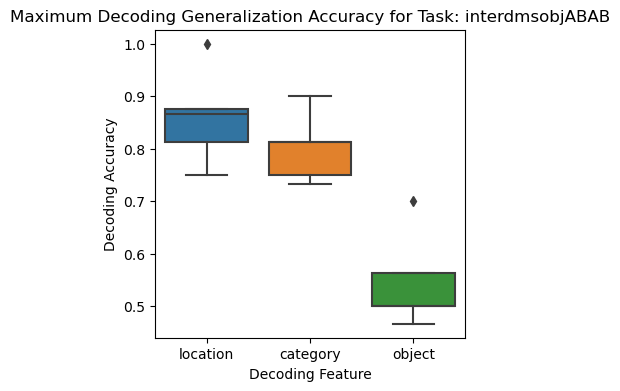

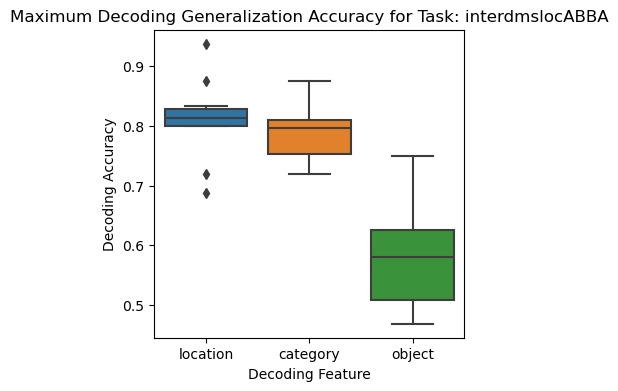

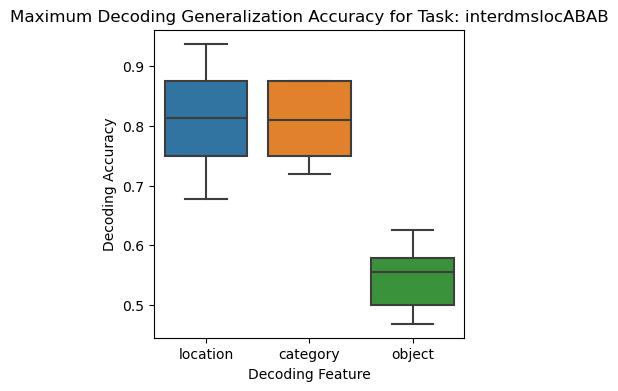

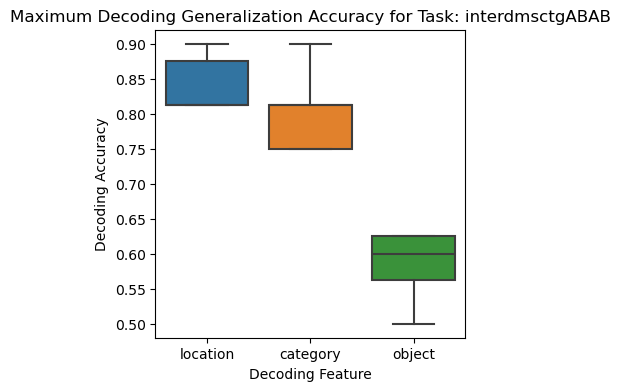

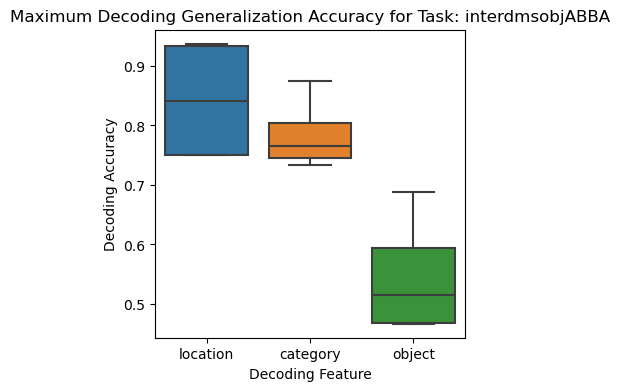

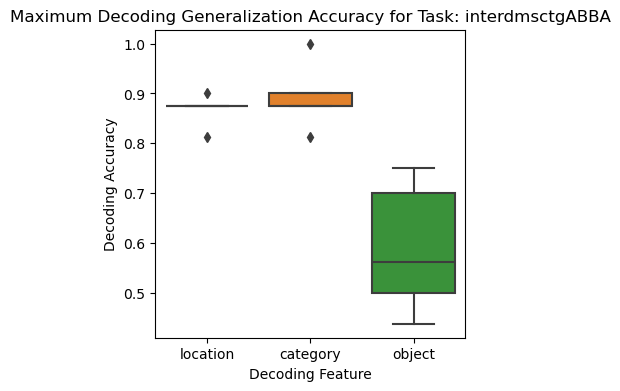

In [87]:
import seaborn as sns

# del generalization_accuracy["1backctg"]
# del generalization_accuracy["1backobj"]

# del corres_test_ratio_accuracy["1backctg"]
# del corres_test_ratio_accuracy["1backobj"]
for task in generalization_accuracy.keys():
    plt.figure(figsize=(4, 4))
    data_to_plot = [generalization_accuracy[task][feature] for feature in decoding_features]
    
    # Create the box plot
    sns.boxplot(data=data_to_plot)
    
    # Annotate each box with its maximum accuracy and corresponding metric
    for feature_index, feature in enumerate(decoding_features):
        max_acc_for_feature = np.max(generalization_accuracy[task][feature])
        corresponding_metric = best_metrics[task][feature]  # Find the metric corresponding to max accuracy
        
        # Calculate the position of the text annotation
        x_position = feature_index
        y_position = max_acc_for_feature + 0.01  # Slightly above the max value
        
        # Add annotation to the plot
        # plt.text(x_position, y_position, f'Max: {max_acc_for_feature:.2f}\n({corresponding_metric})',
        #          ha='center', va='bottom', fontsize=10, color='red', weight='bold')
    
    # Set plot labels and titles
    plt.xticks(ticks=np.arange(len(decoding_features)), labels=decoding_features)
    plt.title(f'Maximum Decoding Generalization Accuracy for Task: {task}')
    plt.ylabel('Decoding Accuracy')
    plt.xlabel('Decoding Feature')
    
    


### mask betas

In [67]:
task_betas.keys()

dict_keys(['1backloc'])

In [68]:
len(mapped_atlas['V1'])

1610

In [69]:
indexes = mapped_atlas['V1']
print(indexes)

for task in task_betas.keys():
    # Across each session
    for sess in task_betas[task].keys():
        # Across each run
        for run in task_betas[task][sess].keys():
            if task == 'dmsloc' and sess == 'ses16' and run == 'run-01':
                print(task_betas[task][sess][run][indexes].shape)

[  103   104   105 ... 58338 58339 58340]


### run decoding

In [48]:
# Decoding function
def decoding(trainset, testset, trainlabels,testlabels,classifier='distance',confusion=False):
    """ in my experience, distance/pearson based decoding is best for fMRI"""
    unique_labels = np.unique(trainlabels)
    
    if classifier in ['distance','cosine']:
        #### Create prototypes from trainset
        prototypes = {}
        for label in unique_labels:
            ind = np.where(trainlabels==label)[0]
            prototypes[label] = np.mean(trainset[ind,:],axis=0)

        #### Now classifiy each sample n the testset
        predictions = []
        for i in range(testset.shape[0]):
            # Correlate sampple with each prototype
            rs = []
            for label in prototypes:
                if classifier == 'distance':
                    rs.append(stats.pearsonr(prototypes[label],testset[i,:])[0])
                if classifier == 'cosine':
                    rs.append(np.dot(prototypes[label],testset[i,:])/(np.linalg.norm(prototypes[label])*np.linalg.norm(testset[i,:])))
            
            # Find the closest prototype for sample
            max_ind = np.argmax(np.asarray(rs))
            predictions.append(unique_labels[max_ind])

        predictions = np.asarray(predictions)

    if classifier == 'logistic':

        #clf = sklearn.linear_model.LogisticRegression(solver='lbfgs',penalty='none',max_iter=1000)
        clf = sklearn.linear_model.LogisticRegression(solver='liblinear')
        clf.fit(trainset,trainlabels)
        predictions = clf.predict(testset)

    if classifier == 'ridge':

        clf = sklearn.linear_model.RidgeClassifier(solver='svd',max_iter=1000)
        clf.fit(trainset,trainlabels)
        predictions = clf.predict(testset)

    if classifier == 'svm':
        clf = svm.SVC(kernel='linear',probability=True)
        clf.fit(trainset,trainlabels)
        predictions = clf.predict(testset)

    accuracy = predictions == np.asarray(testlabels)
    confusion_mat = sklearn.metrics.confusion_matrix(testlabels, predictions, labels=unique_labels)

    if confusion:
        return accuracy, confusion_mat
    else:
        return accuracy

In [49]:
def manual_undersample(trainset, trainlabels):
    # Separate the majority and minority classes
    a = len(trainset[trainlabels == 0])
    b = len(trainset[trainlabels == 1])
    if a>b:
        trainset_majority = trainset[trainlabels == 0]
        trainset_minority = trainset[trainlabels == 1]
    else:
        trainset_majority = trainset[trainlabels == 1]
        trainset_minority = trainset[trainlabels == 0]

    # Get the number of samples in each class
    num_majority = len(trainset_majority)
    num_minority = len(trainset_minority)
    
    # Randomly sample without replacement from the majority class to match the number of minority samples
    indices_to_keep = np.random.choice(np.arange(num_majority), size=num_minority, replace=False)
    trainset_majority_balanced = trainset_majority[indices_to_keep]

    # Combine the balanced majority class with the minority class
    balanced_trainset = np.vstack([trainset_majority_balanced, trainset_minority])
    if a>b:
        balanced_trainlabels = np.hstack([np.zeros(num_minority), np.ones(num_minority)])
    else:
        balanced_trainlabels = np.hstack([np.ones(num_minority), np.zeros(num_minority)])
    return balanced_trainset, balanced_trainlabels

### Encoding phase decoding

/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan

Task 1backloc
	Number of p<0.05: 27
	Number of q<0.05:(after FDR correction) 0
chance: 0.5
['PCV', '23d', '31pv', '7PC', '3a', 'p24pr', '10v', '47s', 'AAIC', 'PreS', 'A5', 'MST', 4, 'POS2', 'A1', '31pv', '7PC', '3a', 'a24pr', 'OFC', '47s', 's6-8', 'AAIC', 'EC', 'TE1a', 'TPOJ2', 'PoI1']
[]
[]


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan

Task 1backloc
	Number of p<0.05: 30
	Number of q<0.05:(after FDR correction) 0
chance: 0.5
['FEF', 'LO2', 'PSL', 2, '8BL', '10d', '8C', '47l', 'a9-\n46v', '9-46d', 'FOP4', 'STSda', 'STSvp', 'TE2a', 'PH', 'TPOJ1', 'PGp', 25, 'p47r', 'V3', 'v23ab', 'VIP', 'TGd', 'TE1a', 'TE2a', 'TPOJ1', 'DVT', 'V6A', 'VVC', 'TE1m']
[]
[]


KeyError: 'identity'

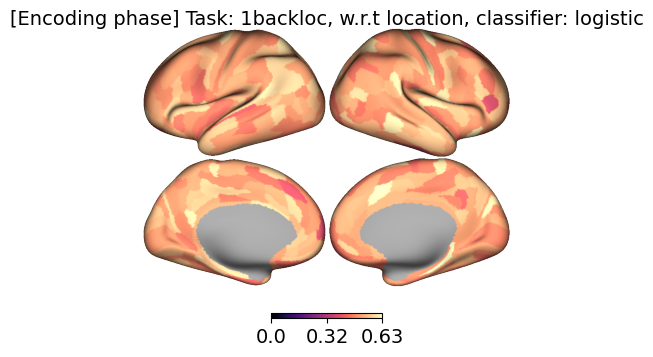

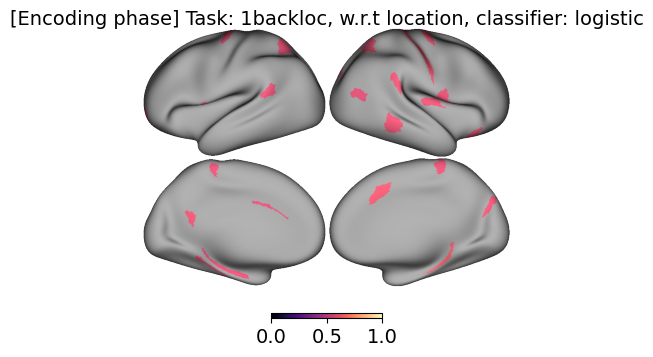

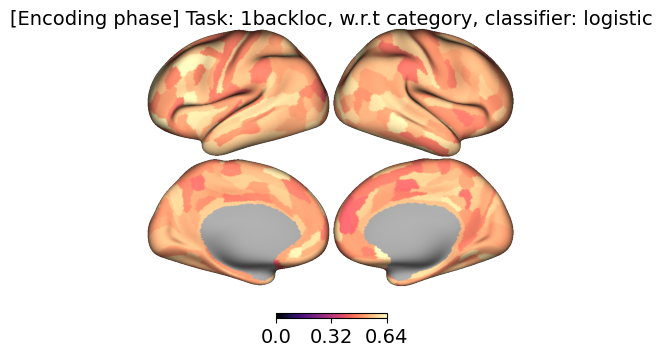

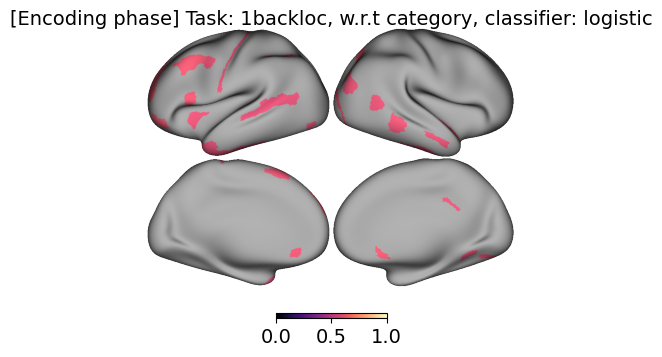

In [51]:
n_bootstraps = 1

encoding_perm_decoding_accuracy = np.zeros((num_regions, n_bootstraps))
encoding_decoding_accuracy = np.zeros((num_regions, n_bootstraps))
encoding_binary_decoding_accuracy = {}
size_regions = []

classifier = "logistic" # choose from distance, cosine, logistic, ridge, svm

phase = "encoding"

for decoding_feature in ["location", "category", ]:
    accuracies[tasks[0]][decoding_feature] = {}
    accuracies[tasks[0]][decoding_feature][phase] = []
    
    # sanity check: decoding for location
    for region in range(0,num_regions): # region IDs are from 1-360
        region_idx = np.where(glasser_atlas==region+1)[0]
        size_regions.append(len(region_idx))
        
        activations = None
        labels = []
        for i, task in enumerate(task_betas_encoding.keys()):
            for sess in task_betas_encoding[task].keys():
                for run in task_betas_encoding[task][sess].keys():
                    curr_activation = task_betas_encoding[task][sess][run][region_idx]
                    if activations is None:
                        activations = curr_activation
                    else:
                        activations = np.concatenate([activations, curr_activation], axis=1)
                    
                    labels.extend(task_df_encoding[task][sess][run][decoding_feature].to_numpy())
                    assert activations.shape[1] == len(labels)
                    # add task index
                    # labels.extend([i] * curr_activation.shape[1])
        n_samples = len(labels)
        labels = np.array(labels)
        acc = []
        perm_acc = []
        binary_decoding_acc = []
        for nb in range(n_bootstraps):
            trainsplit_size = int(n_samples * 0.8)
            all_idx = np.arange(n_samples)
            train_idx = list(np.random.choice(n_samples, trainsplit_size,replace=False))
            test_idx = np.delete(all_idx,train_idx)
            
            # specify labels
            trainlabels = labels[train_idx]
            testlabels =labels[test_idx]
    
        #     # specify data
            trainset = activations[:,train_idx].T
            testset = activations[:,test_idx].T
    
            while len(np.unique(testlabels)) == 1:
                # repeat the sampling procedure
                print("--------------repeat the sampling procedure--------------")
                train_idx = list(np.random.choice(n_samples, trainsplit_size,replace=False))
                test_idx = np.delete(all_idx,train_idx)
                
                # specify labels
                trainlabels = labels[train_idx]
                testlabels =labels[test_idx]
        
            #     # specify data
                trainset = activations[:,train_idx].T
                testset = activations[:,test_idx].T
                
           
            # balanced_trainset, balanced_trainlabels = manual_undersample(trainset, trainlabels)
            # balanced_testset, balanced_testlabels = manual_undersample(testset, testlabels)
            balanced_trainset, balanced_trainlabels = trainset, trainlabels
            balanced_testset, balanced_testlabels = testset, testlabels
            binary_decoding_acc.extend(decoding(balanced_trainset,balanced_testset,balanced_trainlabels,balanced_testlabels,classifier=classifier,confusion=False))
            acc.append(np.mean(binary_decoding_acc[-len(testlabels):]))
        
            
            
            
        #   for permutation test
            np.random.shuffle(balanced_trainlabels)
            perm_acc.append(np.mean(decoding(balanced_trainset,balanced_testset,balanced_trainlabels,balanced_testlabels,classifier=classifier,confusion=False)))
            
        encoding_perm_decoding_accuracy[region, :] = perm_acc
        encoding_decoding_accuracy[region, :] = acc
        encoding_binary_decoding_accuracy[region] = binary_decoding_acc

        
    # visualization on brain surfaces
    from scipy.stats import binomtest
    stats_decoding = np.zeros((num_regions,3,))
    unique_stims = task_df_encoding[task][sess][run][decoding_feature].unique()
    # Calculate accuracy and p-values
    for region in range(num_regions):
        acc = np.mean(encoding_binary_decoding_accuracy[region])
        p = binomtest(np.sum(encoding_binary_decoding_accuracy[region]), n=len(encoding_binary_decoding_accuracy[region]), p=1/len(unique_stims), alternative='greater')
        # if p.pvalue < 0.05:
        #     print("accuracy:",acc)
        #     print("obtained p value:", p.pvalue)
        #     print("total number of trial:", len(encoding_binary_decoding_accuracy[region]))
        #     print("successful trials:", np.sum(encoding_binary_decoding_accuracy[region]))
        
        stats_decoding[region, 0] = acc
        stats_decoding[region, 1] = p.pvalue
    
    # Perform FDR correction
    q = fdrcorrection(stats_decoding[:, 1])[1]
    stats_decoding[:, 2] = q
    
    # Print results
    print('Task', task)
    print('\tNumber of p<0.05:', np.sum(stats_decoding[:, 1] < 0.05))
    print('\tNumber of q<0.05:(after FDR correction)', np.sum(stats_decoding[:, 2] < 0.05))
    print('chance:', 1/len(unique_stims))

    # identify brain regions that are significantly decodable
    # after fdr correction
    fdr_region_indices = np.where(stats_decoding[:, 2] < 0.05)[0]
    filtered_df = map_df[map_df['region_id'].isin(fdr_region_indices)]
    # Extract the region names
    fdr_region_names = filtered_df['region_name'].tolist()
    
    # before fdr correction
    region_indices = np.where(stats_decoding[:, 1] < 0.05)[0]
    filtered_df = map_df[map_df['region_id'].isin(region_indices)]
    # Extract the region names
    region_names = filtered_df['region_name'].tolist()
    
    # Display the result
    print(region_names)
    print(fdr_region_names)
    accuracies[tasks[0]][decoding_feature][phase] = fdr_region_indices


    surfaces = fetch_fslr()
    lh, rh = surfaces['veryinflated']
    surface_dat = np.zeros((len(glasser_atlas),))
    for roi in range(num_regions):
        roi_ind = np.where(glasser_atlas==roi+1)[0]
        surface_dat[roi_ind] = stats_decoding[roi,0]
    
    p = surfplot.Plot(lh,rh,size=(500,350),zoom=1.8)
    p.add_layer(surface_dat.T,cmap='magma',color_range=[np.min(surface_dat), np.max(surface_dat)])
    fig = p.build(figsize=(4,4),colorbar=True,cbar_kws={'fontsize':14})
    fig.suptitle('[Encoding phase] Task: %s, w.r.t %s, classifier: %s' % (task, decoding_feature, classifier),y=0.88,fontsize=14)
    fig.tight_layout()


    surfaces = fetch_fslr()
    lh, rh = surfaces['veryinflated']
    surface_dat = np.zeros((len(glasser_atlas),))
    
    all_significant_regions = []
    for roi in range(num_regions):
        roi_ind = np.where(glasser_atlas==roi+1)[0]
        surface_dat[roi_ind] = stats_decoding[roi,0]*(stats_decoding[roi,1]<0.05)
        
        all_significant_regions.append(stats_decoding[roi,1]<0.05)
    
    
    all_significant_regions = np.where(all_significant_regions == np.unique(all_significant_regions)[1])[0]
    
    filtered_df = map_df[map_df['region_id'].isin(all_significant_regions)]
    # Extract the region names
    encoding_fdr_region_names = filtered_df['region_name'].tolist()
    
    p = surfplot.Plot(lh,rh,size=(500,350),zoom=1.8)
    # p.add_layer(surface_dat.T,cmap='magma',color_range=[np.min(surface_dat), np.max(surface_dat)])
    p.add_layer(surface_dat.T,cmap='magma',color_range=[0,1])
    fig = p.build(figsize=(4,4),colorbar=True,cbar_kws={'fontsize':14})
    fig.suptitle('[Encoding phase] Task: %s, w.r.t %s, classifier: %s' % (task, decoding_feature, classifier),y=0.88,fontsize=14)
    fig.tight_layout()
    print(fdr_region_names)


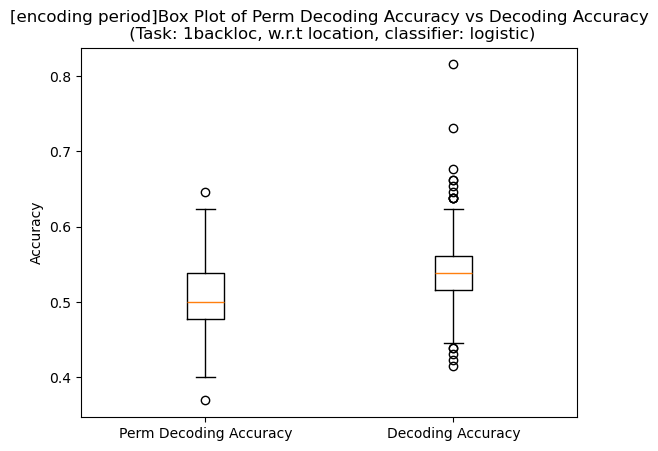

T-test: t-statistic = -9.080314911319517, p-value = 1.0315069825080409e-18
Mann-Whitney U test: U-statistic = 40366.0, p-value = 1.833282017319668e-18


In [80]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu

plt.boxplot([list(np.mean(encoding_perm_decoding_accuracy, axis = -1)), list(np.mean(encoding_decoding_accuracy, axis = -1))], labels=['Perm Decoding Accuracy', 'Decoding Accuracy'])
plt.ylabel('Accuracy')
plt.title('[encoding period]Box Plot of Perm Decoding Accuracy vs Decoding Accuracy\n (Task: %s, w.r.t %s, classifier: %s)' % (task, decoding_feature, classifier))
plt.show()

# Perform a t-test
t_stat, p_value = ttest_ind(list(np.mean(encoding_perm_decoding_accuracy, axis = -1)),  list(np.mean(encoding_decoding_accuracy, axis = -1)))
print(f'T-test: t-statistic = {t_stat}, p-value = {p_value}')

# Perform a Mann-Whitney U test
u_stat, p_value = mannwhitneyu(list(np.mean(encoding_perm_decoding_accuracy, axis = -1)),  list(np.mean(encoding_decoding_accuracy, axis = -1)))
print(f'Mann-Whitney U test: U-statistic = {u_stat}, p-value = {p_value}')

In [81]:
# # sanity check: correlation between n_regions and decoding accuracy
# from scipy.stats import pearsonr, spearmanr
# # Convert lists to numpy arrays
# size_regions = np.array(size_regions)
# decoding_accuracy = np.array(decoding_accuracy)

# # Calculate Pearson and Spearman correlation coefficients
# pearson_corr, pearson_p_value = pearsonr(size_regions, np.mean(decoding_accuracy, axis = -1))
# spearman_corr, spearman_p_value = spearmanr(size_regions, np.mean(decoding_accuracy, axis = -1))

# print(f'Pearson correlation: {pearson_corr}, p-value: {pearson_p_value}')
# print(f'Spearman correlation: {spearman_corr}, p-value: {spearman_p_value}')

# # Create the line plot
# plt.plot(size_regions, np.mean(decoding_accuracy, axis = -1), marker='o', linestyle='-', color='b')
# plt.xlabel('Size of Regions')
# plt.ylabel('Decoding Accuracy')
# plt.title('Correlation between Size of Regions and Decoding Accuracy')
# plt.grid(True)
# plt.show()

In [82]:
# # visualization on brain surfaces
# from scipy.stats import binomtest
# stats_decoding = np.zeros((num_regions,3,))
# unique_stims = task_df_encoding[task][sess][run][decoding_feature].unique()
# # Calculate accuracy and p-values
# for region in range(num_regions):
#     acc = np.mean(encoding_binary_decoding_accuracy[region])
#     p = binomtest(np.sum(encoding_binary_decoding_accuracy[region]), n=len(encoding_binary_decoding_accuracy[region]), p=1/len(unique_stims), alternative='greater')
#     # if p.pvalue < 0.05:
#     #     print("accuracy:",acc)
#     #     print("obtained p value:", p.pvalue)
#     #     print("total number of trial:", len(encoding_binary_decoding_accuracy[region]))
#     #     print("successful trials:", np.sum(encoding_binary_decoding_accuracy[region]))
    
#     stats_decoding[region, 0] = acc
#     stats_decoding[region, 1] = p.pvalue

# # Perform FDR correction
# q = fdrcorrection(stats_decoding[:, 1])[1]
# stats_decoding[:, 2] = q

# # Print results
# print('Task', task)
# print('\tNumber of p<0.05:', np.sum(stats_decoding[:, 1] < 0.05))
# print('\tNumber of q<0.05:(after FDR correction)', np.sum(stats_decoding[:, 2] < 0.05))
# print('chance:', 1/len(unique_stims))


Task 1backloc
	Number of p<0.05: 66
	Number of q<0.05:(after FDR correction) 11
chance: 0.5


In [83]:
# # identify brain regions that are significantly decodable
# # after fdr correction
# fdr_region_indices = np.where(stats_decoding[:, 2] < 0.05)[0]
# filtered_df = map_df[map_df['region_id'].isin(fdr_region_indices)]
# # Extract the region names
# fdr_region_names = filtered_df['region_name'].tolist()

# # before fdr correction
# region_indices = np.where(stats_decoding[:, 1] < 0.05)[0]
# filtered_df = map_df[map_df['region_id'].isin(region_indices)]
# # Extract the region names
# region_names = filtered_df['region_name'].tolist()

# # Display the result
# print(region_names)
# print(fdr_region_names)
# accuracies[tasks[0]][decoding_feature][phase] = fdr_region_indices

['LG', 'V6', 'V2', 'V3', '3b', '55b', 'V7', 'FFC', 'STV', '7m', '5m', '6ma', '7PC', '8BM', 'p32', '10d', '8C', 45, 'a47r', '6r', 46, 'a9-\n46v', '11l', 'FOP2', 'AIP', 'EC', 'PreS', 'H', 'STSdp', 'TF', 'TE2p', 'DVT', 'IP2', 'IP1', 'V4t', 'TGv', 'MBelt', 'TE1m', 'p24', 'LG', 'V2', 'V3', 'V8', 'FEF', 'IPS1', 'FFC', 'LO1', 'PSL', '7Pm', '5mv', '24dd', 'a24', '8C', 'IFJa', 'p9-\n46v', 's6-8', 43, 'AVI', 'PeEc', 'STGa', 'PHA1', 'STSda', 'PFm', 'PGs', 'FST', 'MBelt', 'PI']
['LG', 'V6', 'V2', 'V3', 'TE1m', 'p24', 'LG', 'V2', 'V3', 'AVI', 'STGa', 'MBelt']


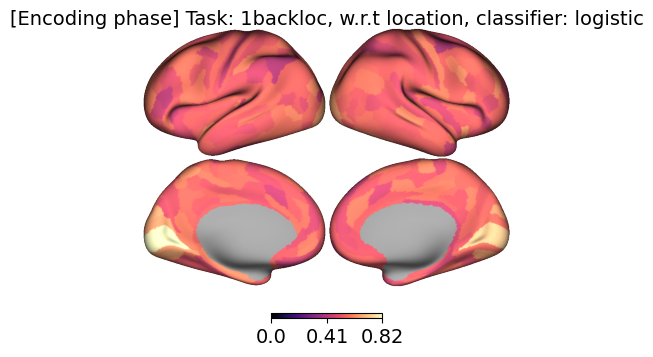

In [84]:
# surfaces = fetch_fslr()
# lh, rh = surfaces['veryinflated']
# surface_dat = np.zeros((len(glasser_atlas),))
# for roi in range(num_regions):
#     roi_ind = np.where(glasser_atlas==roi+1)[0]
#     surface_dat[roi_ind] = stats_decoding[roi,0]

# p = surfplot.Plot(lh,rh,size=(500,350),zoom=1.8)
# p.add_layer(surface_dat.T,cmap='magma',color_range=[np.min(surface_dat), np.max(surface_dat)])
# fig = p.build(figsize=(4,4),colorbar=True,cbar_kws={'fontsize':14})
# fig.suptitle('[Encoding phase] Task: %s, w.r.t %s, classifier: %s' % (task, decoding_feature, classifier),y=0.88,fontsize=14)
# fig.tight_layout()


['LG', 'V6', 'V2', 'V3', 'TE1m', 'p24', 'LG', 'V2', 'V3', 'AVI', 'STGa', 'MBelt']


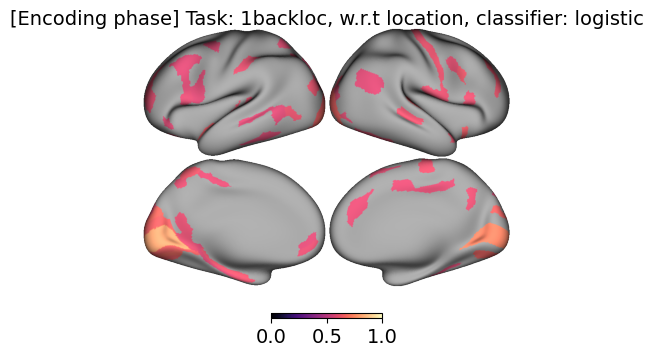

In [85]:
# surfaces = fetch_fslr()
# lh, rh = surfaces['veryinflated']
# surface_dat = np.zeros((len(glasser_atlas),))

# all_significant_regions = []
# for roi in range(num_regions):
#     roi_ind = np.where(glasser_atlas==roi+1)[0]
#     surface_dat[roi_ind] = stats_decoding[roi,0]*(stats_decoding[roi,1]<0.05)
    
#     all_significant_regions.append(stats_decoding[roi,1]<0.05)


# all_significant_regions = np.where(all_significant_regions == np.unique(all_significant_regions)[1])[0]

# filtered_df = map_df[map_df['region_id'].isin(all_significant_regions)]
# # Extract the region names
# encoding_fdr_region_names = filtered_df['region_name'].tolist()

# p = surfplot.Plot(lh,rh,size=(500,350),zoom=1.8)
# # p.add_layer(surface_dat.T,cmap='magma',color_range=[np.min(surface_dat), np.max(surface_dat)])
# p.add_layer(surface_dat.T,cmap='magma',color_range=[0,1])
# fig = p.build(figsize=(4,4),colorbar=True,cbar_kws={'fontsize':14})
# fig.suptitle('[Encoding phase] Task: %s, w.r.t %s, classifier: %s' % (task, decoding_feature, classifier),y=0.88,fontsize=14)
# fig.tight_layout()
# print(fdr_region_names)

## Delay phase decoding

accuracy: 0.568
accuracy: 0.544
accuracy: 0.512
accuracy: 0.6
accuracy: 0.544
accuracy: 0.44
accuracy: 0.536
accuracy: 0.576
accuracy: 0.504
accuracy: 0.528
accuracy: 0.56
accuracy: 0.568
accuracy: 0.512
accuracy: 0.472
accuracy: 0.504
accuracy: 0.488
accuracy: 0.496
accuracy: 0.464
accuracy: 0.456
accuracy: 0.48
accuracy: 0.44
accuracy: 0.512
accuracy: 0.472
accuracy: 0.488
accuracy: 0.496
accuracy: 0.456
accuracy: 0.624
accuracy: 0.512
accuracy: 0.496
accuracy: 0.552
accuracy: 0.552
accuracy: 0.44
accuracy: 0.448
accuracy: 0.464
accuracy: 0.584
accuracy: 0.464
accuracy: 0.44
accuracy: 0.4
accuracy: 0.536
accuracy: 0.504
accuracy: 0.496
accuracy: 0.52
accuracy: 0.496
accuracy: 0.464
accuracy: 0.584
accuracy: 0.496
accuracy: 0.56
accuracy: 0.496
accuracy: 0.504
accuracy: 0.456
accuracy: 0.496
accuracy: 0.496
accuracy: 0.464
accuracy: 0.4
accuracy: 0.472
accuracy: 0.544
accuracy: 0.592
accuracy: 0.544
accuracy: 0.504
accuracy: 0.536
accuracy: 0.496
accuracy: 0.648
accuracy: 0.48
accurac

/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.472
accuracy: 0.464
accuracy: 0.52
accuracy: 0.576
accuracy: 0.52
accuracy: 0.584
accuracy: 0.52
accuracy: 0.48


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.464


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.584
accuracy: 0.544


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.584


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.56
accuracy: 0.496
accuracy: 0.536
accuracy: 0.464
accuracy: 0.552
accuracy: 0.536
accuracy: 0.552
accuracy: 0.464
accuracy: 0.496
accuracy: 0.52
accuracy: 0.56
accuracy: 0.456
accuracy: 0.496
accuracy: 0.536
accuracy: 0.56
accuracy: 0.488
accuracy: 0.44
accuracy: 0.552
accuracy: 0.568
accuracy: 0.64
accuracy: 0.448
accuracy: 0.536
accuracy: 0.52
accuracy: 0.536
accuracy: 0.536
accuracy: 0.496
accuracy: 0.576
accuracy: 0.504
accuracy: 0.512
accuracy: 0.504
accuracy: 0.576
accuracy: 0.536
accuracy: 0.496
accuracy: 0.512
accuracy: 0.52
accuracy: 0.504
accuracy: 0.512


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.504
accuracy: 0.496
accuracy: 0.544
accuracy: 0.536
accuracy: 0.528
accuracy: 0.472
accuracy: 0.368
accuracy: 0.504
accuracy: 0.52
accuracy: 0.496
accuracy: 0.552
accuracy: 0.52
accuracy: 0.496
accuracy: 0.536
accuracy: 0.496
accuracy: 0.528
accuracy: 0.536
accuracy: 0.48
accuracy: 0.432
accuracy: 0.472
accuracy: 0.496
accuracy: 0.56
accuracy: 0.432
accuracy: 0.576
accuracy: 0.504
accuracy: 0.432
accuracy: 0.512
accuracy: 0.544
accuracy: 0.536
accuracy: 0.48
accuracy: 0.576
accuracy: 0.584
accuracy: 0.472
accuracy: 0.504
accuracy: 0.464
accuracy: 0.592
accuracy: 0.48
accuracy: 0.536
accuracy: 0.496
accuracy: 0.48
accuracy: 0.52
accuracy: 0.544
accuracy: 0.56
accuracy: 0.504
accuracy: 0.472
accuracy: 0.456
accuracy: 0.528
accuracy: 0.424
accuracy: 0.48
accuracy: 0.544
accuracy: 0.568
accuracy: 0.448
accuracy: 0.52
accuracy: 0.456
accuracy: 0.48
accuracy: 0.528
accuracy: 0.528
accuracy: 0.488
accuracy: 0.408
accuracy: 0.472
accuracy: 0.464
accuracy: 0.448
accuracy: 0.488
accu

/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.52


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.512
accuracy: 0.552
accuracy: 0.472
accuracy: 0.52
accuracy: 0.488
accuracy: 0.48
accuracy: 0.568
accuracy: 0.528
accuracy: 0.528
accuracy: 0.576
accuracy: 0.472
accuracy: 0.584
accuracy: 0.568
accuracy: 0.528
accuracy: 0.528
accuracy: 0.536
accuracy: 0.464
accuracy: 0.504
accuracy: 0.52
accuracy: 0.488
accuracy: 0.536
accuracy: 0.576
accuracy: 0.52
accuracy: 0.432
accuracy: 0.464
accuracy: 0.504
accuracy: 0.544
accuracy: 0.488
accuracy: 0.536
accuracy: 0.456
accuracy: 0.472
accuracy: 0.512
accuracy: 0.504
accuracy: 0.496
accuracy: 0.568
accuracy: 0.504
accuracy: 0.472
accuracy: 0.528
accuracy: 0.496
accuracy: 0.496


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.456


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.552
accuracy: 0.552
accuracy: 0.472
accuracy: 0.488
accuracy: 0.52
accuracy: 0.544
accuracy: 0.512
accuracy: 0.56
Task 1backloc
	Number of p<0.05: 22
	Number of q<0.05:(after FDR correction) 0
chance: 0.5
['V6', 'SFL', 'd23ab', '6ma', '6v', 'a24', '6r', 'a10p', '6a', 'OP2-3', 'PHA3', 'TGd', 'TE1p', 'VMV1', 'PIT', 'SFL', '9m', 46, 'a9-\n46v', 'OFC', 'AAIC', 'DVT']
[]
[]
accuracy: 0.504
accuracy: 0.528
accuracy: 0.584
accuracy: 0.544
accuracy: 0.472
accuracy: 0.44
accuracy: 0.52
accuracy: 0.464
accuracy: 0.544
accuracy: 0.512
accuracy: 0.512
accuracy: 0.504
accuracy: 0.48
accuracy: 0.512
accuracy: 0.528
accuracy: 0.48
accuracy: 0.576
accuracy: 0.504
accuracy: 0.528
accuracy: 0.56
accuracy: 0.544
accuracy: 0.616
accuracy: 0.472
accuracy: 0.528
accuracy: 0.552
accuracy: 0.624
accuracy: 0.512
accuracy: 0.584
accuracy: 0.464
accuracy: 0.472
accuracy: 0.504
accuracy: 0.536
accuracy: 0.48
accuracy: 0.56
accuracy: 0.584
accuracy: 0.536
accuracy: 0.488
accuracy: 0.528
accuracy: 0.592

/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.528
accuracy: 0.448
accuracy: 0.648
accuracy: 0.6
accuracy: 0.528
accuracy: 0.472
accuracy: 0.52
accuracy: 0.584


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.592


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.464
accuracy: 0.472
accuracy: 0.56
accuracy: 0.576
accuracy: 0.568
accuracy: 0.488
accuracy: 0.544
accuracy: 0.48
accuracy: 0.488
accuracy: 0.528
accuracy: 0.664
accuracy: 0.536
accuracy: 0.616
accuracy: 0.512
accuracy: 0.472
accuracy: 0.504
accuracy: 0.544
accuracy: 0.52
accuracy: 0.56
accuracy: 0.512
accuracy: 0.504
accuracy: 0.512
accuracy: 0.52
accuracy: 0.592
accuracy: 0.56
accuracy: 0.424
accuracy: 0.488
accuracy: 0.488
accuracy: 0.56
accuracy: 0.48
accuracy: 0.488
accuracy: 0.528
accuracy: 0.528
accuracy: 0.536
accuracy: 0.504
accuracy: 0.424
accuracy: 0.576
accuracy: 0.528
accuracy: 0.544
accuracy: 0.488


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.544


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.584
accuracy: 0.464
accuracy: 0.536
accuracy: 0.424
accuracy: 0.536
accuracy: 0.448
accuracy: 0.608
accuracy: 0.536
accuracy: 0.488
accuracy: 0.4
accuracy: 0.568
accuracy: 0.552
accuracy: 0.456
accuracy: 0.496
accuracy: 0.52
accuracy: 0.528
accuracy: 0.52
accuracy: 0.576
accuracy: 0.496
accuracy: 0.528
accuracy: 0.552
accuracy: 0.512
accuracy: 0.536
accuracy: 0.472
accuracy: 0.552
accuracy: 0.448
accuracy: 0.552
accuracy: 0.568
accuracy: 0.552
accuracy: 0.592
accuracy: 0.512
accuracy: 0.632
accuracy: 0.536
accuracy: 0.472
accuracy: 0.424
accuracy: 0.616
accuracy: 0.632
accuracy: 0.576
accuracy: 0.472
accuracy: 0.432
accuracy: 0.488
accuracy: 0.528
accuracy: 0.576
accuracy: 0.528
accuracy: 0.44
accuracy: 0.496
accuracy: 0.464
accuracy: 0.496
accuracy: 0.448
accuracy: 0.544
accuracy: 0.496
accuracy: 0.56
accuracy: 0.504
accuracy: 0.464
accuracy: 0.496
accuracy: 0.52
accuracy: 0.528
accuracy: 0.56
accuracy: 0.584
accuracy: 0.432
accuracy: 0.464
accuracy: 0.472
accuracy: 0.48
a

/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.568


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.488
accuracy: 0.52
accuracy: 0.44
accuracy: 0.584
accuracy: 0.52
accuracy: 0.552
accuracy: 0.568
accuracy: 0.488
accuracy: 0.576
accuracy: 0.504
accuracy: 0.512
accuracy: 0.488
accuracy: 0.52
accuracy: 0.544
accuracy: 0.52
accuracy: 0.52
accuracy: 0.4
accuracy: 0.536
accuracy: 0.504
accuracy: 0.592
accuracy: 0.528
accuracy: 0.536
accuracy: 0.584
accuracy: 0.472
accuracy: 0.456
accuracy: 0.512
accuracy: 0.6
accuracy: 0.568
accuracy: 0.536
accuracy: 0.536
accuracy: 0.52
accuracy: 0.624
accuracy: 0.512
accuracy: 0.52
accuracy: 0.504
accuracy: 0.472
accuracy: 0.432
accuracy: 0.448
accuracy: 0.504
accuracy: 0.536


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.528


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.568
accuracy: 0.584
accuracy: 0.504
accuracy: 0.416
accuracy: 0.52
accuracy: 0.52
accuracy: 0.512
accuracy: 0.52
Task 1backloc
	Number of p<0.05: 38
	Number of q<0.05:(after FDR correction) 3
chance: 0.5
['MST', 'LO2', 'PSL', 'PCV', 'd23ab', '23c', '7PC', 'a10p', '11l', 'FOP2', 'PreS', 'PBelt', 'A5', 'STSdp', 'STSvp', 'TPOJ3', 'PGp', 'VMV3', 'TGv', 'PI', 'LO2', 'MT', 'PCV', 'STV', 'MIP', 'p32pr', '10r', 'a10p', 'FOP4', 'AVI', 'FOP1', 'FOP3', 'TE2a', 'PGi', 'VMV1', 'FST', '31a', 'MBelt']
['PreS', 'TPOJ3', '10r']
['PreS', 'TPOJ3', '10r']


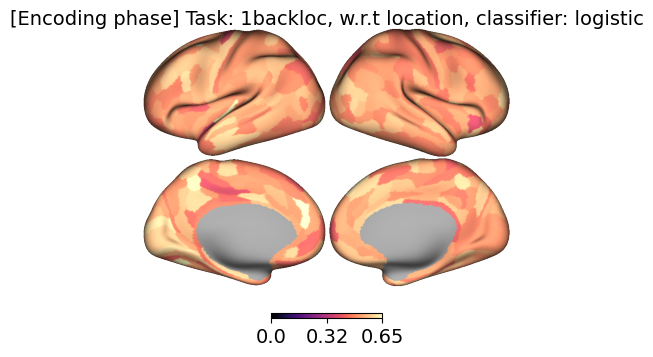

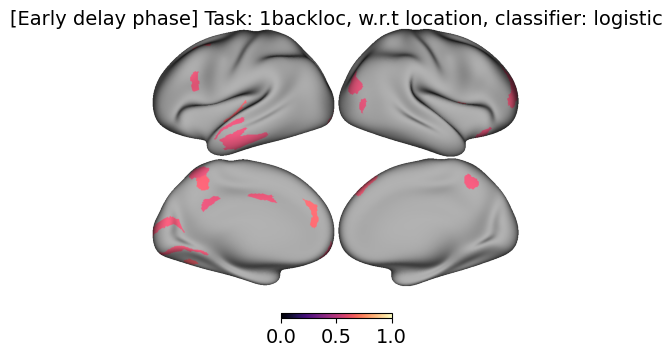

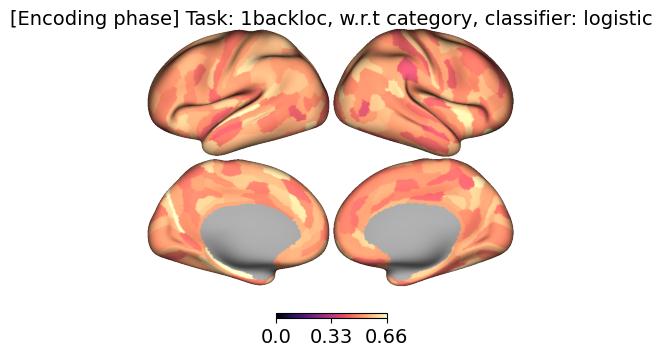

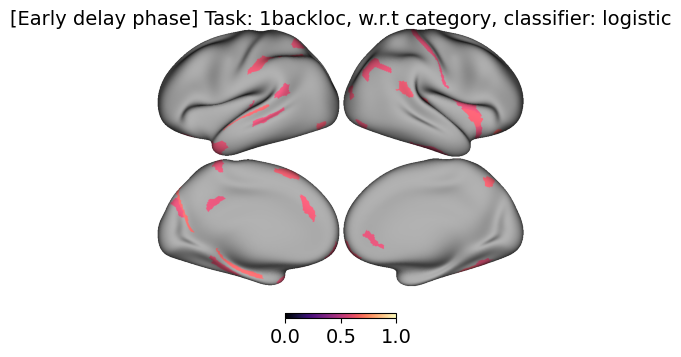

In [83]:
n_bootstraps = 1
delay_perm_decoding_accuracy = np.zeros((num_regions, n_bootstraps))
delay_decoding_accuracy = np.zeros((num_regions, n_bootstraps))
delay_binary_decoding_accuracy = {}
delay_size_regions = []
# decoding_feature = "category"
# classifier = "logistic" # choose from distance, cosine, logistic, ridge, svm

phase = "early_delay"

for decoding_feature in ["location", "category"]:
    accuracies[tasks[0]][decoding_feature] = {}   
    accuracies[tasks[0]][decoding_feature][phase] = []

    # sanity check: decoding for location
    for region in range(0,num_regions): # region IDs are from 1-360
        region_idx = np.where(glasser_atlas==region+1)[0]
        size_regions.append(len(region_idx))
        
        activations = None
        labels = []
        for i, task in enumerate(task_betas_early_delay.keys()):
            for sess in task_betas_early_delay[task].keys():
                for run in task_betas_early_delay[task][sess].keys():
                    curr_activation = task_betas_early_delay[task][sess][run][region_idx]
                    if activations is None:
                        activations = curr_activation
                    else:
                        activations = np.concatenate([activations, curr_activation], axis=1)
                    
                    labels.extend(task_df_early_delay[task][sess][run][decoding_feature].to_numpy())
                    assert activations.shape[1] == len(labels)
                    # add task index
                    # labels.extend([i] * curr_activation.shape[1])
        n_samples = len(labels)
        labels = np.array(labels)
        acc = []
        perm_acc = []
        binary_decoding_acc = []
        for nb in range(n_bootstraps):
            trainsplit_size = int(n_samples * 0.8)
            all_idx = np.arange(n_samples)
            train_idx = list(np.random.choice(n_samples, trainsplit_size,replace=False))
            test_idx = np.delete(all_idx,train_idx)
            
            # specify labels
            trainlabels = labels[train_idx]
            testlabels =labels[test_idx]
    
        #     # specify data
            trainset = activations[:,train_idx].T
            testset = activations[:,test_idx].T
    
            while len(np.unique(testlabels)) == 1:
                # repeat the sampling procedure
                print("--------------repeat the sampling procedure--------------")
                train_idx = list(np.random.choice(n_samples, trainsplit_size,replace=False))
                test_idx = np.delete(all_idx,train_idx)
                
                # specify labels
                trainlabels = labels[train_idx]
                testlabels =labels[test_idx]
    
            #     # specify data
                trainset = activations[:,train_idx].T
                testset = activations[:,test_idx].T
                
        
            # balanced_trainset, balanced_trainlabels = manual_undersample(trainset, trainlabels)
            # balanced_testset, balanced_testlabels = manual_undersample(testset, testlabels)
            balanced_trainset, balanced_trainlabels = trainset, trainlabels
            balanced_testset, balanced_testlabels = testset, testlabels
            binary_decoding_acc.extend(decoding(balanced_trainset,balanced_testset,balanced_trainlabels,balanced_testlabels,classifier=classifier,confusion=False))
            acc.append(np.mean(binary_decoding_acc[-len(testlabels):]))
        
            print("accuracy:", acc[-1])
            
            
        #   for permutation test
            np.random.shuffle(balanced_trainlabels)
            perm_acc.append(np.mean(decoding(balanced_trainset,balanced_testset,balanced_trainlabels,balanced_testlabels,classifier=classifier,confusion=False)))
            
        delay_perm_decoding_accuracy[region, :] = perm_acc
        delay_decoding_accuracy[region, :] = acc
        delay_binary_decoding_accuracy[region] = binary_decoding_acc

    # visualization on brain surfaces
    from scipy.stats import binomtest
    stats_decoding = np.zeros((num_regions,3,))
    unique_stims = task_df_early_delay[task][sess][run][decoding_feature].unique()
    # Calculate accuracy and p-values
    for region in range(num_regions):
        acc = np.mean(delay_binary_decoding_accuracy[region])
        p = binomtest(np.sum(delay_binary_decoding_accuracy[region]), n=len(delay_binary_decoding_accuracy[region]), p=1/len(unique_stims), alternative='greater')
        stats_decoding[region, 0] = acc
        stats_decoding[region, 1] = p.pvalue
    
    # Perform FDR correction
    q = fdrcorrection(stats_decoding[:, 1])[1]
    stats_decoding[:, 2] = q
    
    # Print results
    print('Task', task)
    print('\tNumber of p<0.05:', np.sum(stats_decoding[:, 1] < 0.05))
    print('\tNumber of q<0.05:(after FDR correction)', np.sum(stats_decoding[:, 2] < 0.05))
    print('chance:', 1/len(unique_stims))

    # identify brain regions that are significantly decodable
    # after fdr correction
    fdr_region_indices = np.where(stats_decoding[:, 2] < 0.05)[0]
    filtered_df = map_df[map_df['region_id'].isin(fdr_region_indices)]
    # Extract the region names
    fdr_region_names = filtered_df['region_name'].tolist()
    
    # before fdr correction
    region_indices = np.where(stats_decoding[:, 1] < 0.05)[0]
    filtered_df = map_df[map_df['region_id'].isin(region_indices)]
    # Extract the region names
    region_names = filtered_df['region_name'].tolist()
    
    # Display the result
    print(region_names)
    print(fdr_region_names)
    
    accuracies[tasks[0]][decoding_feature][phase] = fdr_region_indices
  
    surfaces = fetch_fslr()
    lh, rh = surfaces['veryinflated']
    surface_dat = np.zeros((len(glasser_atlas),))
    for roi in range(num_regions):
        roi_ind = np.where(glasser_atlas==roi+1)[0]
        surface_dat[roi_ind] = stats_decoding[roi,0]
    
    p = surfplot.Plot(lh,rh,size=(500,350),zoom=1.8)
    p.add_layer(surface_dat.T,cmap='magma',color_range=[np.min(surface_dat), np.max(surface_dat)])
    fig = p.build(figsize=(4,4),colorbar=True,cbar_kws={'fontsize':14})
    fig.suptitle('[Early Delay phase] Task: %s, w.r.t %s, classifier: %s' % (task, decoding_feature, classifier),y=0.88,fontsize=14)
    fig.tight_layout()


    surfaces = fetch_fslr()
    lh, rh = surfaces['veryinflated']
    surface_dat = np.zeros((len(glasser_atlas),))
    
    all_significant_regions = []
    for roi in range(num_regions):
        roi_ind = np.where(glasser_atlas==roi+1)[0]
        surface_dat[roi_ind] = stats_decoding[roi,0]*(stats_decoding[roi,1]<0.05)
        
        all_significant_regions.append(stats_decoding[roi,1]<0.05)
    
    
    all_significant_regions = np.where(all_significant_regions == np.unique(all_significant_regions)[1])[0]
    
    filtered_df = map_df[map_df['region_id'].isin(all_significant_regions)]
    # Extract the region names
    encoding_fdr_region_names = filtered_df['region_name'].tolist()
    
    p = surfplot.Plot(lh,rh,size=(500,350),zoom=1.8)
    # p.add_layer(surface_dat.T,cmap='magma',color_range=[np.min(surface_dat), np.max(surface_dat)])
    p.add_layer(surface_dat.T,cmap='magma',color_range=[0,1])
    fig = p.build(figsize=(4,4),colorbar=True,cbar_kws={'fontsize':14})
    fig.suptitle('[Early delay phase] Task: %s, w.r.t %s, classifier: %s' % (task, decoding_feature, classifier),y=0.88,fontsize=14)
    fig.tight_layout()
    print(fdr_region_names)


In [73]:
task_df_delay[task][sess]

{}

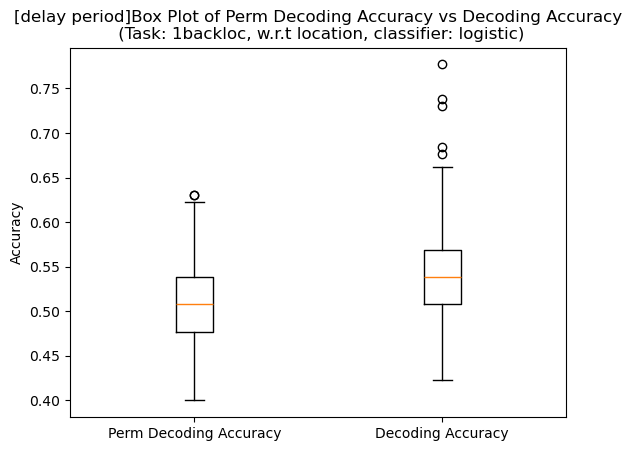

T-test: t-statistic = -9.844652405291829, p-value = 1.5511784385525445e-21
Mann-Whitney U test: U-statistic = 39174.5, p-value = 3.779941234276097e-20


In [87]:
# import matplotlib.pyplot as plt
# from scipy.stats import ttest_ind, mannwhitneyu

# plt.boxplot([list(np.mean(delay_perm_decoding_accuracy, axis = -1)), list(np.mean(delay_decoding_accuracy, axis = -1))], labels=['Perm Decoding Accuracy', 'Decoding Accuracy'])
# plt.ylabel('Accuracy')
# plt.title('[delay period]Box Plot of Perm Decoding Accuracy vs Decoding Accuracy\n (Task: %s, w.r.t %s, classifier: %s)' % (task, decoding_feature, classifier))
# plt.show()

# # Perform a t-test
# t_stat, p_value = ttest_ind(list(np.mean(delay_perm_decoding_accuracy, axis = -1)),  list(np.mean(delay_decoding_accuracy, axis = -1)))
# print(f'T-test: t-statistic = {t_stat}, p-value = {p_value}')

# # Perform a Mann-Whitney U test
# u_stat, p_value = mannwhitneyu(list(np.mean(delay_perm_decoding_accuracy, axis = -1)),  list(np.mean(delay_decoding_accuracy, axis = -1)))
# print(f'Mann-Whitney U test: U-statistic = {u_stat}, p-value = {p_value}')

In [88]:
# # visualization on brain surfaces
# from scipy.stats import binomtest
# stats_decoding = np.zeros((num_regions,3,))
# unique_stims = task_df_delay[task][sess][run][decoding_feature].unique()
# # Calculate accuracy and p-values
# for region in range(num_regions):
#     acc = np.mean(delay_binary_decoding_accuracy[region])
#     p = binomtest(np.sum(delay_binary_decoding_accuracy[region]), n=len(delay_binary_decoding_accuracy[region]), p=1/len(unique_stims), alternative='greater')
#     stats_decoding[region, 0] = acc
#     stats_decoding[region, 1] = p.pvalue

# # Perform FDR correction
# q = fdrcorrection(stats_decoding[:, 1])[1]
# stats_decoding[:, 2] = q

# # Print results
# print('Task', task)
# print('\tNumber of p<0.05:', np.sum(stats_decoding[:, 1] < 0.05))
# print('\tNumber of q<0.05:(after FDR correction)', np.sum(stats_decoding[:, 2] < 0.05))
# print('chance:', 1/len(unique_stims))


Task 1backloc
	Number of p<0.05: 80
	Number of q<0.05:(after FDR correction) 17
chance: 0.5


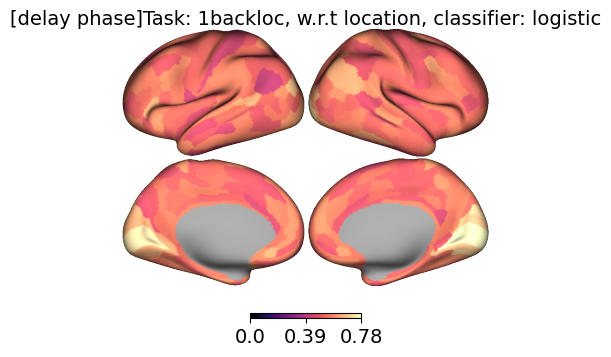

In [89]:
# surfaces = fetch_fslr()
# lh, rh = surfaces['veryinflated']
# surface_dat = np.zeros((len(glasser_atlas),))
# for roi in range(num_regions):
#     roi_ind = np.where(glasser_atlas==roi+1)[0]
#     surface_dat[roi_ind] = stats_decoding[roi,0]

# p = surfplot.Plot(lh,rh,size=(500,350),zoom=1.8)
# p.add_layer(surface_dat.T,cmap='magma',color_range=[np.min(surface_dat), np.max(surface_dat)])
# fig = p.build(figsize=(4,4),colorbar=True,cbar_kws={'fontsize':14})
# fig.suptitle('[delay phase]Task: %s, w.r.t %s, classifier: %s' % (task, decoding_feature, classifier),y=0.88,fontsize=14)
# fig.tight_layout()


In [90]:
# # identify brain regions that are significantly decodable
# # after fdr correction
# fdr_region_indices = np.where(stats_decoding[:, 2] < 0.05)[0]
# filtered_df = map_df[map_df['region_id'].isin(fdr_region_indices)]
# # Extract the region names
# fdr_region_names = filtered_df['region_name'].tolist()

# # before fdr correction
# region_indices = np.where(stats_decoding[:, 1] < 0.05)[0]
# filtered_df = map_df[map_df['region_id'].isin(region_indices)]
# # Extract the region names
# region_names = filtered_df['region_name'].tolist()

# # Display the result
# print(region_names)
# print(fdr_region_names)

# accuracies[tasks[0]][decoding_feature][phase] = fdr_region_indices

['LG', 'V6', 'V2', 'V3', 'FEF', '55b', 'LO1', 'LO2', '23c', 'SCEF', '7PC', 'LIPv', '8BM', '8Ad', '9m', 44, '47l', '6r', 'IFJa', 'p9-\n46v', '9-46d', '9a', '10pp', 'RI', 'MI', 'Pir', 'AIP', 'H', 'PBelt', 'PHA1', 'STSvp', 'PH', 'TPOJ2', 'DVT', 'LO3', 'VVC', 25, 's32', 'Ig', 'TGv', 'PI', 'p24', 'LG', 'V6', 'V2', 'V3', 'FEF', '55b', 'RSC', 'LO2', 'A1', 'SFL', 'PCV', '23c', '24dv', '7Pl', 'LIPv', 1, '8Ad', '47l', '6r', 'IFJa', '13l', 'OFC', 'LIPd', 'PoI2', 'AIP', 'STGa', 'STSda', 'TF', 'TPOJ2', 'TPOJ3', 'PFm', 'PGi', 'VMV1', 'VMV3', 'FST', 'LO3', 25, 'MBelt', 'LBelt']
['LG', 'V6', 'V2', '55b', 44, 'H', 'PH', 'DVT', 25, 'p24', 'LG', 'V6', 'V2', 'TF', 'PFm', 'PGi', 'FST', 'MBelt']


['LG', 'V6', 'V2', '55b', 44, 'H', 'PH', 'DVT', 25, 'p24', 'LG', 'V6', 'V2', 'TF', 'PFm', 'PGi', 'FST', 'MBelt']


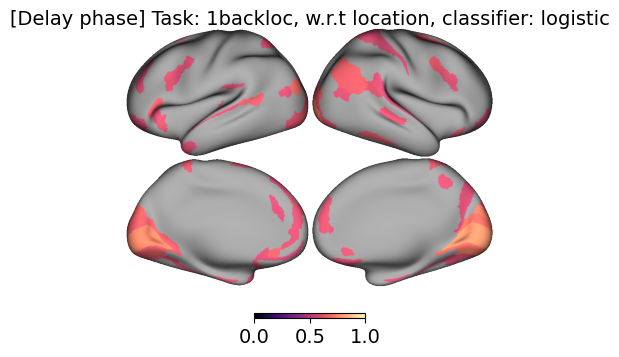

In [91]:
# surfaces = fetch_fslr()
# lh, rh = surfaces['veryinflated']
# surface_dat = np.zeros((len(glasser_atlas),))

# all_significant_regions = []
# for roi in range(num_regions):
#     roi_ind = np.where(glasser_atlas==roi+1)[0]
#     surface_dat[roi_ind] = stats_decoding[roi,0]*(stats_decoding[roi,1]<0.05)
#     all_significant_regions.append(stats_decoding[roi,1]<0.05)


# all_significant_regions = np.where(all_significant_regions == np.unique(all_significant_regions)[1])[0]

# filtered_df = map_df[map_df['region_id'].isin(all_significant_regions)]
# # Extract the region names
# delay_fdr_region_names = filtered_df['region_name'].tolist()

# p = surfplot.Plot(lh,rh,size=(500,350),zoom=1.8)
# p.add_layer(surface_dat.T,cmap='magma',color_range=[0,1])
# fig = p.build(figsize=(4,4),colorbar=True,cbar_kws={'fontsize':14})
# fig.suptitle('[Delay phase] Task: %s, w.r.t %s, classifier: %s' % (task, decoding_feature, classifier),y=0.88,fontsize=14)
# fig.tight_layout()
# print(fdr_region_names)

accuracy: 0.472
accuracy: 0.56
accuracy: 0.552
accuracy: 0.44
accuracy: 0.512
accuracy: 0.472
accuracy: 0.616
accuracy: 0.568
accuracy: 0.424
accuracy: 0.536
accuracy: 0.44
accuracy: 0.544
accuracy: 0.504
accuracy: 0.464
accuracy: 0.544
accuracy: 0.512
accuracy: 0.504
accuracy: 0.52
accuracy: 0.528
accuracy: 0.56
accuracy: 0.552
accuracy: 0.536
accuracy: 0.512
accuracy: 0.496
accuracy: 0.552
accuracy: 0.536
accuracy: 0.472
accuracy: 0.52
accuracy: 0.496
accuracy: 0.512
accuracy: 0.52
accuracy: 0.44
accuracy: 0.568
accuracy: 0.544
accuracy: 0.44
accuracy: 0.496
accuracy: 0.456
accuracy: 0.472
accuracy: 0.48
accuracy: 0.48
accuracy: 0.448
accuracy: 0.536
accuracy: 0.504
accuracy: 0.512
accuracy: 0.544
accuracy: 0.496
accuracy: 0.544
accuracy: 0.456
accuracy: 0.552
accuracy: 0.568
accuracy: 0.4
accuracy: 0.528
accuracy: 0.544
accuracy: 0.488
accuracy: 0.48
accuracy: 0.496
accuracy: 0.488
accuracy: 0.552
accuracy: 0.536
accuracy: 0.488
accuracy: 0.472
accuracy: 0.608
accuracy: 0.496
accura

/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.432


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.512
accuracy: 0.536
accuracy: 0.512
accuracy: 0.496
accuracy: 0.48
accuracy: 0.64
accuracy: 0.424
accuracy: 0.416


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.568


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.488
accuracy: 0.552


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.488
accuracy: 0.56
accuracy: 0.464
accuracy: 0.576
accuracy: 0.432
accuracy: 0.488
accuracy: 0.512
accuracy: 0.504
accuracy: 0.6
accuracy: 0.576
accuracy: 0.568
accuracy: 0.472
accuracy: 0.552
accuracy: 0.52
accuracy: 0.568
accuracy: 0.528
accuracy: 0.608
accuracy: 0.448
accuracy: 0.536
accuracy: 0.472
accuracy: 0.52
accuracy: 0.456
accuracy: 0.56
accuracy: 0.456
accuracy: 0.464
accuracy: 0.552
accuracy: 0.456
accuracy: 0.576
accuracy: 0.512
accuracy: 0.456
accuracy: 0.496
accuracy: 0.528
accuracy: 0.56
accuracy: 0.52
accuracy: 0.48
accuracy: 0.504
accuracy: 0.456
accuracy: 0.48


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.568


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.552
accuracy: 0.568
accuracy: 0.528
accuracy: 0.48
accuracy: 0.528
accuracy: 0.512
accuracy: 0.56
accuracy: 0.544
accuracy: 0.552
accuracy: 0.496
accuracy: 0.496
accuracy: 0.544
accuracy: 0.496
accuracy: 0.56
accuracy: 0.536
accuracy: 0.496
accuracy: 0.496
accuracy: 0.488
accuracy: 0.576
accuracy: 0.6
accuracy: 0.568
accuracy: 0.528
accuracy: 0.528
accuracy: 0.52
accuracy: 0.544
accuracy: 0.512
accuracy: 0.552
accuracy: 0.504
accuracy: 0.528
accuracy: 0.496
accuracy: 0.544
accuracy: 0.52
accuracy: 0.528
accuracy: 0.464
accuracy: 0.552
accuracy: 0.472
accuracy: 0.44
accuracy: 0.488
accuracy: 0.504
accuracy: 0.496
accuracy: 0.464
accuracy: 0.496
accuracy: 0.512
accuracy: 0.456
accuracy: 0.52
accuracy: 0.472
accuracy: 0.448
accuracy: 0.56
accuracy: 0.528
accuracy: 0.48
accuracy: 0.512
accuracy: 0.464
accuracy: 0.424
accuracy: 0.432
accuracy: 0.48
accuracy: 0.496
accuracy: 0.544
accuracy: 0.528
accuracy: 0.456
accuracy: 0.528
accuracy: 0.504
accuracy: 0.488
accuracy: 0.504
accu

/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.52


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.552
accuracy: 0.496
accuracy: 0.44
accuracy: 0.48
accuracy: 0.504
accuracy: 0.568
accuracy: 0.504
accuracy: 0.44
accuracy: 0.544
accuracy: 0.488
accuracy: 0.552
accuracy: 0.624
accuracy: 0.496
accuracy: 0.456
accuracy: 0.544
accuracy: 0.52
accuracy: 0.528
accuracy: 0.52
accuracy: 0.456
accuracy: 0.464
accuracy: 0.512
accuracy: 0.584
accuracy: 0.512
accuracy: 0.456
accuracy: 0.44
accuracy: 0.512
accuracy: 0.472
accuracy: 0.52
accuracy: 0.48
accuracy: 0.504
accuracy: 0.456
accuracy: 0.432
accuracy: 0.592
accuracy: 0.384
accuracy: 0.536
accuracy: 0.488
accuracy: 0.488
accuracy: 0.496
accuracy: 0.496
accuracy: 0.528


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.52


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.512
accuracy: 0.512
accuracy: 0.528
accuracy: 0.552
accuracy: 0.528
accuracy: 0.592
accuracy: 0.472
accuracy: 0.56
Task 1backloc
	Number of p<0.05: 18
	Number of q<0.05:(after FDR correction) 0
chance: 0.5
['V4', 'a24', '10r', '8C', 'IFSp', '10pp', 'PHA3', 'TPOJ3', 'PFm', 'PEF', 'p32', '8C', 'FOP2', 'STGa', 'DVT', 'V6A', 'VVC', 'TE1m']
[]
[]
accuracy: 0.52
accuracy: 0.496
accuracy: 0.584
accuracy: 0.584
accuracy: 0.52
accuracy: 0.504
accuracy: 0.464
accuracy: 0.528
accuracy: 0.52
accuracy: 0.504
accuracy: 0.552
accuracy: 0.48
accuracy: 0.536
accuracy: 0.496
accuracy: 0.568
accuracy: 0.456
accuracy: 0.424
accuracy: 0.512
accuracy: 0.464
accuracy: 0.496
accuracy: 0.496
accuracy: 0.624
accuracy: 0.544
accuracy: 0.456
accuracy: 0.592
accuracy: 0.544
accuracy: 0.448
accuracy: 0.512
accuracy: 0.472
accuracy: 0.56
accuracy: 0.552
accuracy: 0.472
accuracy: 0.432
accuracy: 0.496
accuracy: 0.544
accuracy: 0.6
accuracy: 0.544
accuracy: 0.496
accuracy: 0.512
accuracy: 0.568
accuracy: 0

/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.52


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.504
accuracy: 0.44
accuracy: 0.544
accuracy: 0.504
accuracy: 0.56
accuracy: 0.6
accuracy: 0.584
accuracy: 0.48
accuracy: 0.48
accuracy: 0.504
accuracy: 0.512
accuracy: 0.56
accuracy: 0.384
accuracy: 0.56
accuracy: 0.528
accuracy: 0.544
accuracy: 0.592
accuracy: 0.416
accuracy: 0.488
accuracy: 0.504
accuracy: 0.496
accuracy: 0.6
accuracy: 0.528
accuracy: 0.52
accuracy: 0.552
accuracy: 0.488
accuracy: 0.472
accuracy: 0.512
accuracy: 0.448
accuracy: 0.536
accuracy: 0.528
accuracy: 0.552
accuracy: 0.488
accuracy: 0.424
accuracy: 0.536
accuracy: 0.528
accuracy: 0.488
accuracy: 0.512
accuracy: 0.52
accuracy: 0.544


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.52


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.472
accuracy: 0.504
accuracy: 0.48
accuracy: 0.48
accuracy: 0.456
accuracy: 0.448
accuracy: 0.48
accuracy: 0.536
accuracy: 0.496
accuracy: 0.528
accuracy: 0.432
accuracy: 0.536
accuracy: 0.52
accuracy: 0.64
accuracy: 0.544
accuracy: 0.544
accuracy: 0.496
accuracy: 0.512
accuracy: 0.456
accuracy: 0.496
accuracy: 0.552
accuracy: 0.488
accuracy: 0.52
accuracy: 0.488
accuracy: 0.632
accuracy: 0.52
accuracy: 0.44
accuracy: 0.512
accuracy: 0.6
accuracy: 0.592
accuracy: 0.432
accuracy: 0.552
accuracy: 0.616
accuracy: 0.52
accuracy: 0.528
accuracy: 0.504
accuracy: 0.608
accuracy: 0.504
accuracy: 0.456
accuracy: 0.432
accuracy: 0.544
accuracy: 0.504
accuracy: 0.52
accuracy: 0.496
accuracy: 0.52
accuracy: 0.536
accuracy: 0.504
accuracy: 0.456
accuracy: 0.544
accuracy: 0.568
accuracy: 0.456
accuracy: 0.472
accuracy: 0.528
accuracy: 0.44
accuracy: 0.512
accuracy: 0.552
accuracy: 0.544
accuracy: 0.536
accuracy: 0.504
accuracy: 0.552
accuracy: 0.4
accuracy: 0.504
accuracy: 0.488
accuracy

/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.544


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.496
accuracy: 0.536
accuracy: 0.496
accuracy: 0.504
accuracy: 0.528
accuracy: 0.56
accuracy: 0.512
accuracy: 0.496
accuracy: 0.6
accuracy: 0.44
accuracy: 0.496
accuracy: 0.488
accuracy: 0.568
accuracy: 0.488
accuracy: 0.56
accuracy: 0.528
accuracy: 0.464
accuracy: 0.512
accuracy: 0.456
accuracy: 0.552
accuracy: 0.544
accuracy: 0.528
accuracy: 0.52
accuracy: 0.544
accuracy: 0.56
accuracy: 0.472
accuracy: 0.552
accuracy: 0.56
accuracy: 0.568
accuracy: 0.512
accuracy: 0.456
accuracy: 0.576
accuracy: 0.552
accuracy: 0.472
accuracy: 0.496
accuracy: 0.536
accuracy: 0.512
accuracy: 0.52
accuracy: 0.48
accuracy: 0.496


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.576


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.568
accuracy: 0.536
accuracy: 0.48
accuracy: 0.448
accuracy: 0.448
accuracy: 0.528
accuracy: 0.528
accuracy: 0.472
Task 1backloc
	Number of p<0.05: 33
	Number of q<0.05:(after FDR correction) 0
chance: 0.5
['MST', 'V6', 'LO2', 'A1', '31pv', '6ma', '6v', '10d', 'AVI', 'AAIC', 'FOP2', 'STGa', 'A5', 'STSda', 'TE2p', 'PHT', 'PFop', 'V6A', 'V3', 'V7', 'LO1', 'LO2', 'A1', 'STV', 'p32', '10r', '8Ad', 'IFSa', 43, 'PoI2', 'FOP2', 'EC', 'TPOJ1']
[]
[]


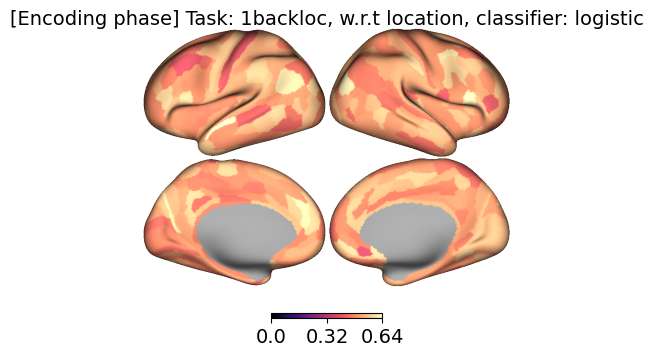

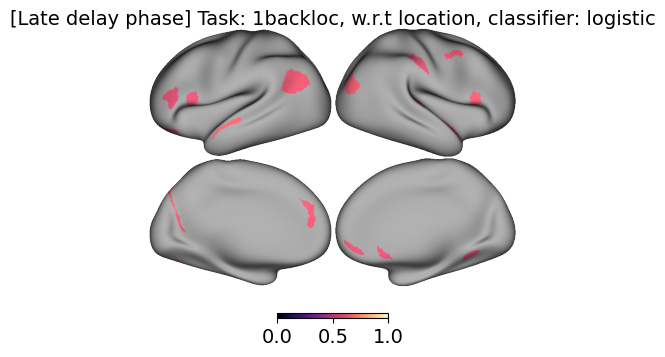

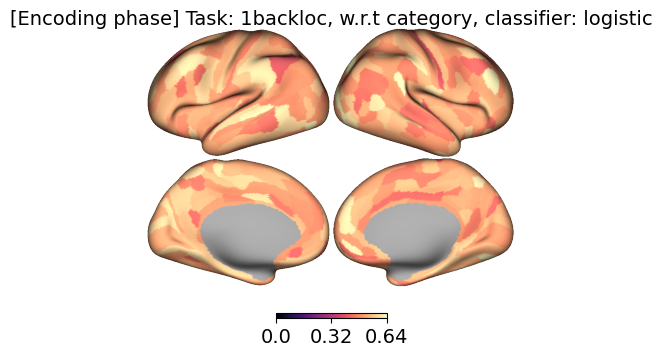

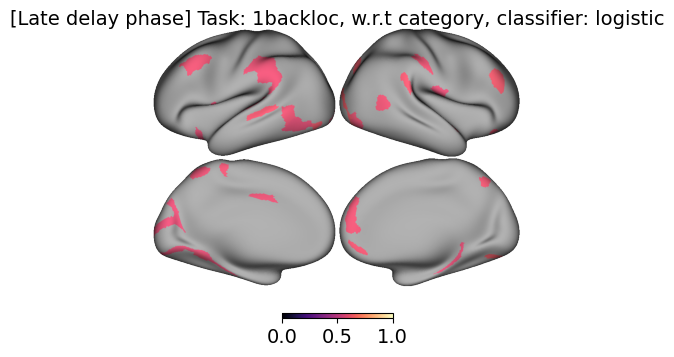

In [84]:
# late delay phase decoding
n_bootstraps = 1
delay_perm_decoding_accuracy = np.zeros((num_regions, n_bootstraps))
delay_decoding_accuracy = np.zeros((num_regions, n_bootstraps))
delay_binary_decoding_accuracy = {}
delay_size_regions = []
# decoding_feature = "category"
# classifier = "logistic" # choose from distance, cosine, logistic, ridge, svm

phase = "late_delay"

for decoding_feature in ["location", "category"]:
    accuracies[tasks[0]][decoding_feature] = {}   
    accuracies[tasks[0]][decoding_feature][phase] = []

    # sanity check: decoding for location
    for region in range(0,num_regions): # region IDs are from 1-360
        region_idx = np.where(glasser_atlas==region+1)[0]
        size_regions.append(len(region_idx))
        
        activations = None
        labels = []
        for i, task in enumerate(task_betas_late_delay.keys()):
            for sess in task_betas_late_delay[task].keys():
                for run in task_betas_late_delay[task][sess].keys():
                    curr_activation = task_betas_late_delay[task][sess][run][region_idx]
                    if activations is None:
                        activations = curr_activation
                    else:
                        activations = np.concatenate([activations, curr_activation], axis=1)
                    
                    labels.extend(task_df_late_delay[task][sess][run][decoding_feature].to_numpy())
                    assert activations.shape[1] == len(labels)
                    # add task index
                    # labels.extend([i] * curr_activation.shape[1])
        n_samples = len(labels)
        labels = np.array(labels)
        acc = []
        perm_acc = []
        binary_decoding_acc = []
        for nb in range(n_bootstraps):
            trainsplit_size = int(n_samples * 0.8)
            all_idx = np.arange(n_samples)
            train_idx = list(np.random.choice(n_samples, trainsplit_size,replace=False))
            test_idx = np.delete(all_idx,train_idx)
            
            # specify labels
            trainlabels = labels[train_idx]
            testlabels =labels[test_idx]
    
        #     # specify data
            trainset = activations[:,train_idx].T
            testset = activations[:,test_idx].T
    
            while len(np.unique(testlabels)) == 1:
                # repeat the sampling procedure
                print("--------------repeat the sampling procedure--------------")
                train_idx = list(np.random.choice(n_samples, trainsplit_size,replace=False))
                test_idx = np.delete(all_idx,train_idx)
                
                # specify labels
                trainlabels = labels[train_idx]
                testlabels =labels[test_idx]
    
            #     # specify data
                trainset = activations[:,train_idx].T
                testset = activations[:,test_idx].T
                
        
            # balanced_trainset, balanced_trainlabels = manual_undersample(trainset, trainlabels)
            # balanced_testset, balanced_testlabels = manual_undersample(testset, testlabels)
            balanced_trainset, balanced_trainlabels = trainset, trainlabels
            balanced_testset, balanced_testlabels = testset, testlabels
            binary_decoding_acc.extend(decoding(balanced_trainset,balanced_testset,balanced_trainlabels,balanced_testlabels,classifier=classifier,confusion=False))
            acc.append(np.mean(binary_decoding_acc[-len(testlabels):]))
        
            print("accuracy:", acc[-1])
            
            
        #   for permutation test
            np.random.shuffle(balanced_trainlabels)
            perm_acc.append(np.mean(decoding(balanced_trainset,balanced_testset,balanced_trainlabels,balanced_testlabels,classifier=classifier,confusion=False)))
            
        delay_perm_decoding_accuracy[region, :] = perm_acc
        delay_decoding_accuracy[region, :] = acc
        delay_binary_decoding_accuracy[region] = binary_decoding_acc

    # visualization on brain surfaces
    from scipy.stats import binomtest
    stats_decoding = np.zeros((num_regions,3,))
    unique_stims = task_df_late_delay[task][sess][run][decoding_feature].unique()
    # Calculate accuracy and p-values
    for region in range(num_regions):
        acc = np.mean(delay_binary_decoding_accuracy[region])
        p = binomtest(np.sum(delay_binary_decoding_accuracy[region]), n=len(delay_binary_decoding_accuracy[region]), p=1/len(unique_stims), alternative='greater')
        stats_decoding[region, 0] = acc
        stats_decoding[region, 1] = p.pvalue
    
    # Perform FDR correction
    q = fdrcorrection(stats_decoding[:, 1])[1]
    stats_decoding[:, 2] = q
    
    # Print results
    print('Task', task)
    print('\tNumber of p<0.05:', np.sum(stats_decoding[:, 1] < 0.05))
    print('\tNumber of q<0.05:(after FDR correction)', np.sum(stats_decoding[:, 2] < 0.05))
    print('chance:', 1/len(unique_stims))

    # identify brain regions that are significantly decodable
    # after fdr correction
    fdr_region_indices = np.where(stats_decoding[:, 2] < 0.05)[0]
    filtered_df = map_df[map_df['region_id'].isin(fdr_region_indices)]
    # Extract the region names
    fdr_region_names = filtered_df['region_name'].tolist()
    
    # before fdr correction
    region_indices = np.where(stats_decoding[:, 1] < 0.05)[0]
    filtered_df = map_df[map_df['region_id'].isin(region_indices)]
    # Extract the region names
    region_names = filtered_df['region_name'].tolist()
    
    # Display the result
    print(region_names)
    print(fdr_region_names)
    
    accuracies[tasks[0]][decoding_feature][phase] = fdr_region_indices
  
    surfaces = fetch_fslr()
    lh, rh = surfaces['veryinflated']
    surface_dat = np.zeros((len(glasser_atlas),))
    for roi in range(num_regions):
        roi_ind = np.where(glasser_atlas==roi+1)[0]
        surface_dat[roi_ind] = stats_decoding[roi,0]
    
    p = surfplot.Plot(lh,rh,size=(500,350),zoom=1.8)
    p.add_layer(surface_dat.T,cmap='magma',color_range=[np.min(surface_dat), np.max(surface_dat)])
    fig = p.build(figsize=(4,4),colorbar=True,cbar_kws={'fontsize':14})
    fig.suptitle('[Encoding phase] Task: %s, w.r.t %s, classifier: %s' % (task, decoding_feature, classifier),y=0.88,fontsize=14)
    fig.tight_layout()


    surfaces = fetch_fslr()
    lh, rh = surfaces['veryinflated']
    surface_dat = np.zeros((len(glasser_atlas),))
    
    all_significant_regions = []
    for roi in range(num_regions):
        roi_ind = np.where(glasser_atlas==roi+1)[0]
        surface_dat[roi_ind] = stats_decoding[roi,0]*(stats_decoding[roi,1]<0.05)
        
        all_significant_regions.append(stats_decoding[roi,1]<0.05)
    
    
    all_significant_regions = np.where(all_significant_regions == np.unique(all_significant_regions)[1])[0]
    
    filtered_df = map_df[map_df['region_id'].isin(all_significant_regions)]
    # Extract the region names
    encoding_fdr_region_names = filtered_df['region_name'].tolist()
    
    p = surfplot.Plot(lh,rh,size=(500,350),zoom=1.8)
    # p.add_layer(surface_dat.T,cmap='magma',color_range=[np.min(surface_dat), np.max(surface_dat)])
    p.add_layer(surface_dat.T,cmap='magma',color_range=[0,1])
    fig = p.build(figsize=(4,4),colorbar=True,cbar_kws={'fontsize':14})
    fig.suptitle('[Late delay phase] Task: %s, w.r.t %s, classifier: %s' % (task, decoding_feature, classifier),y=0.88,fontsize=14)
    fig.tight_layout()
    print(fdr_region_names)


In [92]:
# difference = list(set(encoding_fdr_region_names) - set(delay_fdr_region_names))
# print("regions in encoding but not in delay:", difference)
# difference = list(set(delay_fdr_region_names) - set(encoding_fdr_region_names))
# print("regions in delay but not in encoding:", difference)

regions in encoding but not in delay: ['IPS1', 'V7', '5mv', 'TE1m', '6ma', 'a47r', 'a9-\n46v', '10d', 'PSL', 'p32', 43, 45, 46, 'STV', 'a24', '5m', 'V8', '7m', '7Pm', 'PGs', '3b', '8C', 'IP2', 'PeEc', 's6-8', '11l', 'FFC', 'STSdp', 'TE2p', 'V4t', 'AVI', 'PreS', 'FOP2', 'EC', 'IP1', '24dd']
regions in delay but not in encoding: [1, 'LO2', 'TPOJ2', 'LIPd', 'Ig', 's32', 'OFC', 'PGi', 'LBelt', 'LO3', 25, 'LIPv', 'PoI2', '7Pl', '23c', 'VMV3', 44, '9a', '47l', '9-46d', 'PCV', 'TPOJ3', 'A1', 'PH', '9m', 'STSvp', 'MI', 'PBelt', '8Ad', 'VVC', '24dv', 'RSC', 'SFL', '13l', 'VMV1', 'SCEF', 'RI', 'Pir', '10pp']


In [95]:
accuracies

{'dmsloc': {'location': {'encoding': array([  0,   3,   4,   5,  12,  17,  19,  20,  21, 151, 153, 157, 164,
          180, 183, 184, 185, 186, 192, 199, 202, 225, 227, 229, 322, 333,
          335, 337, 338]),
   'delay': array([  0,   3,   4,   5,  12,  16,  18,  19,  20,  21, 142, 155, 157,
          180, 183, 184, 185, 192, 208, 316, 335, 337, 338, 340])}},
 '1backloc': {'location': {'encoding': array([  0,   3,   4, 128, 180, 183, 184, 218, 337])},
  'category': {'encoding': array([ 20,  78, 151, 311, 337])},
  'identity': {'encoding': []}}}